# Homework 4 - Getting to know your customers

Over time, the Banking sector has dabbled into plenty of Data Science applications. The latter includes topics such as Fraud detection, risk modelling for investment, personalized marketing, managing customer data and customer segmentation, among others. The latter is a crucial topic for a bank since they can offer their products more accurately and tailor-made depending on their clients' characteristics and how probable they will consume more services from the bank.

Now, you and your team have been hired by a bank to get to know their customers. In other words, you will implement hashing and clustering techniques to extract relevant information and highlights from those clients and their transactions.

Then, let's get started!

## VERY VERY IMPORTANT!

1. !!! Read the entire homework before coding anything!!! \
2. My solution is not better than yours, and yours is not better than mine. A data-driven analysis does not have a unique way of solving a problem. For this reason, it is crucial (necessary and mandatory) that you describe any single decision you take and all the steps you follow. \
3. Once performed any exercise, comments about the obtained results are mandatory. We are not always explicit about where to focus your comments, but we will always want brief sentences about your discoveries and decisions.

### 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) that takes as input information about a consumer and finds people similar to the one in the study.

#### 1.1 Set up the data

1. To start working download the [banking dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) on Kaggle.
2. For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

***

In [2]:
import pandas as pd
import numpy as np
import math
import pickle
import random
import seaborn as sns
import time
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics.cluster import adjusted_rand_score

import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import scipy as sc
from scipy.spatial.distance import cdist 
from scipy.spatial import distance
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import metrics
import qwikidata
import qwikidata.sparql
import json
from numpy.random import uniform
from sklearn.datasets import make_blobs

In [2]:
# function that professor Galasso showed us in the laboratory to plot multiple dataframe togheter
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

Loading and preprocessing of the dataset

In [3]:
data = pd.read_csv('bank_transactions.csv')
data.dropna(inplace=True)

In [4]:
# convert male-female into 0-1
data.CustGender = np.where(data.CustGender=='M', 0, 1)

# from date of birth we create a new column called generations that divides all the ages in 3 classes 
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB'] - pd.DateOffset(years=100)
data.drop(data.loc[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
data['CustomerAge'] = ((pd.to_datetime('2016/06/15') - data.CustomerDOB)/np.timedelta64(1,'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)
data['Generation'] = pd.cut(x=data.CustomerAge, bins=[0, 30, 60, 120], labels=[11, 12, 13])

# create 100 classes trough quantiles for the variable 'CustAccountBalance'
AccBal_quantiles = list(data.CustAccountBalance.quantile(np.linspace(.01, 1, 99, 0), 'lower'))
AccBal_quantiles.insert(0, -math.inf)
AccBal_quantiles.insert(100, math.inf)
data['BalanceClass'] = pd.cut(x=data.CustAccountBalance, bins=AccBal_quantiles, 
                                  labels=list(range(101, 201)))

# create 10 classes trough quantiles for the variable 'TransactionAmount (INR)'
TransAmount_quantiles = list(data['TransactionAmount (INR)'].quantile(np.linspace(.01, 1, 9, 0), 'lower'))
TransAmount_quantiles.insert(0, -math.inf)
TransAmount_quantiles.insert(10, math.inf)
data['TrAmClass'] = pd.cut(x=data['TransactionAmount (INR)'], bins=TransAmount_quantiles, 
                                  labels=list(range(1001, 1011)))

In [5]:
# create a subset with only the columns needed
sub_data = data[['CustGender', 'Generation', 'BalanceClass', 'TrAmClass']].copy()
sub_data.head()

,CustGender,Generation,BalanceClass,TrAmClass
0,1,11,153,1002
1,0,12,118,1010
2,1,11,153,1006
3,1,12,199,1009
4,1,11,132,1009


In [5]:
with open("sub_data.pkl", "wb") as file:
    pickle.dump(sub_data, file)

In [ ]:
with open("sub_data.pkl", "rb") as file:
    sub_data = pickle.load(file)

***

#### 1.2 Fingerprint hashing

Using the previously selected data with the features you found pertinent, you have to:

1. Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf).

2. Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

***

Step 1: create the list of shingles (every class of every column)

In [6]:
# initialize the list that will contain all the shingle
shingles = []
# goes trough all the column
for col in sub_data:
    # take all the unique values of that column
    shingles.append(list(sub_data[col].unique()))
# flatten the list
tot_shingles = np.array([item for sublist in shingles for item in sublist])

Step 2: define a function to create the dataframe (rows=shingles | columns=users) that will contain 1 if the user has that shingle and 0 otherwise

In [7]:
def get_shingles_df(data):
    # initialize the dictionary that will have the users as columns and the shingles as rows
    feature_dict = defaultdict(list)

    for row in range(len(data)):
        user = np.array(data.iloc[row])
        for shingle in tot_shingles:
            if shingle in user:
                feature_dict[row].append(1)
            else:
                feature_dict[row].append(0)
                    
    return pd.DataFrame.from_dict(feature_dict)

In [8]:
shingles_df = get_shingles_df(sub_data)
shingles_df.head()

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,1,0,1,1,1,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,1,...,0,0,1,1,1,1,1,1,1,1
2,1,0,1,0,1,0,1,0,1,0,...,0,1,1,0,1,1,1,1,0,0
3,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# to save as a file
with open("shingles_df.pkl", "wb") as file:
    pickle.dump(shingles_df, file)

In [5]:
with open("shingles_df.pkl", "rb") as file:
    shingles_df = pickle.load(file)

Step 3: define a function to create the signature matrix (rows=permutations | columns=users) that contains the position of the first non zero values 

In [9]:
def get_signature_matrix(shingles_df, permutations):
    # Creating the signature matrix
    sig_mat_dict = dict()
    seed = 123
    for perm in range(permutations):
        seed += 1
        permuted_df = shuffle(shingles_df, random_state=seed)
        sig_mat_dict[perm] = list(permuted_df.ne(0).idxmax()+1)
        
    return pd.DataFrame.from_dict(sig_mat_dict).transpose()

In [10]:
n_permutations = 64
signature_matrix = get_signature_matrix(shingles_df, n_permutations)
signature_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,985312,985313,985314,985315,985316,985317,985318,985319,985320,985321
0,6,2,6,4,1,4,11,2,1,2,...,4,1,2,2,2,2,2,2,2,2
1,106,7,3,8,3,110,3,111,3,14,...,22,3,63,2,3,3,3,3,2,2
2,1,107,1,1,1,1,1,12,1,113,...,1,1,110,107,3,102,3,110,19,68
3,6,7,6,8,3,4,11,111,3,113,...,22,3,2,2,2,102,48,2,2,2
4,106,7,6,4,9,110,110,12,3,14,...,110,3,63,89,3,110,3,110,19,68


In [16]:
# to save as a file
with open("signature_matrix.pkl", "wb") as file:
    pickle.dump(signature_matrix, file)

In [6]:
with open("signature_matrix.pkl", "rb") as file:
    signature_matrix = pickle.load(file)

Step 4: define an hashing function (not necessary)

In [11]:
# creating my hash function
def my_hash(key, length):
    random.seed(123)
    alpha = random.sample(range(1000000), length)
    beta = random.sample(range(1000000), length)
    return np.dot(alpha*np.array(key), beta)%1000003

Step 5: define a function to assign every user to a bucket

In [12]:
# create a function that given the signature matrix and the number of bands return the buckets
def assign_buckets(sig_matrix, permutations, n_bands):
    # how many rows to consider
    rows = int(permutations / n_bands)
    # initialize the dict for the buckets
    bucks = dict()
    # goes trough every users
    for col in sig_matrix:
        # goes trough chunks of shingles
        for i in range(0, len(sig_matrix), rows):
            # create the keys for the buckets
            bucket_hash = my_hash(tuple(sig_matrix[col].iloc[i : i + rows]), rows)
            # if the key is already in the dict we only add the column otherwise we create a 'new entry'
            if bucket_hash in bucks:
                bucks[bucket_hash].add(col)
            else:
                bucks[bucket_hash] = {col}
    return bucks

Step 6: try with different bands in order to choose the best one

In [12]:
bands_list = [2, 4, 8, 16]

for band in bands_list:
    buckets = assign_buckets(signature_matrix, n_permutations, band)
    buckets_len = []
    for key in buckets.keys():
        buckets_len.append(len(buckets[key]))
    print(f'With band length equal to {band} --> {len(buckets)} different buckets have been created')
    print(f'With band length equal to {band} --> The average length of the buckets is: {round(np.mean(buckets_len), 2)}')

985322it [05:26, 3014.90it/s]         


With band length equal to 2 --> 11253 different buckets have been created
With band length equal to 2 --> The average length of the buckets is: 175.12


985322it [07:42, 2129.66it/s]         


With band length equal to 4 --> 22218 different buckets have been created
With band length equal to 4 --> The average length of the buckets is: 177.39


985322it [13:28, 1218.18it/s]         


With band length equal to 8 --> 38181 different buckets have been created
With band length equal to 8 --> The average length of the buckets is: 206.45


985322it [24:12, 678.50it/s]                    


With band length equal to 16 --> 33820 different buckets have been created
With band length equal to 16 --> The average length of the buckets is: 454.53


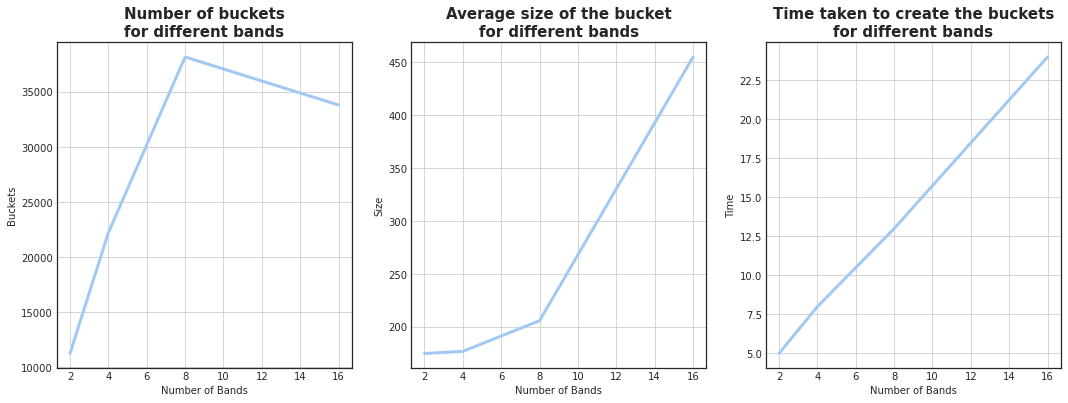

In [14]:
time_list = [5, 8, 13, 24]
buckets_number = [11253, 22218, 38181, 33820]
buckets_length = [175, 177, 206, 455]

plt.figure(1, figsize=(18,6))

color1 = sns.color_palette("pastel")[0]

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 1)
    a = sns.lineplot(x=bands_list, y=buckets_number, color=color1, linewidth=3)
    plt.title("Number of buckets\nfor different bands", fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel("Buckets")

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 2)
    b = sns.lineplot(x=bands_list, y=buckets_length, color=color1, linewidth=3)
    plt.title('Average size of the bucket\nfor different bands', fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel('Size')

with plt.style.context("seaborn-white"):
    plt.rcParams["axes.grid"] = True
    plt.subplot(1, 3, 3)
    c = sns.lineplot(x=bands_list, y=time_list, color=color1, linewidth=3)
    plt.title('Time taken to create the buckets\nfor different bands', fontsize='15', fontweight="bold")
    plt.xlabel("Number of Bands")
    plt.ylabel('Time')

plt.show()

The best choice is to set n_bands equal to: 8

In [13]:
n_bands = 8
buckets = assign_buckets(signature_matrix, n_permutations, n_bands)

In [31]:
# to save as a file
with open("buckets.pkl", "wb") as file:
    pickle.dump(buckets, file)

In [47]:
with open("buckets.pkl", "rb") as file:
    buckets = pickle.load(file)

***

#### 1.3 Locality Sensitive Hashing

Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download [this csv](https://drive.google.com/file/d/1ob7l9vuujfy8cSNWlpt1shcHWXeLHxPs/view?usp=sharing) and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results.

***

Loading and preprocessing the query dataset

In [14]:
query = pd.read_csv('query_users.csv')
query.dropna(inplace=True)

In [15]:
# all the transformations done before for the dataset

query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query.loc[query.CustomerDOB.dt.year > 2000,'CustomerDOB'] = query.loc[query.CustomerDOB.dt.year > 2000,'CustomerDOB'] - pd.DateOffset(years=100)
query.drop(query.loc[query.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

query.CustGender = np.where(query.CustGender=='M', 0, 1)

query['CustomerAge'] = ((pd.to_datetime('2016/06/15') - query.CustomerDOB)/np.timedelta64(1,'Y')).round(0)
query['CustomerAge'] = query['CustomerAge'].astype(int)

query['Generation'] = pd.cut(x=query.CustomerAge, bins=[0, 30, 60, 120], labels=[11, 12, 13])

query['BalanceClass'] = pd.cut(x=query.CustAccountBalance, bins=AccBal_quantiles, 
                                  labels=list(range(101, 201)))

query['TrAmClass'] = pd.cut(x=query['TransactionAmount (INR)'], bins=TransAmount_quantiles, 
                                  labels=list(range(1001, 1011)))

In [16]:
# creating a subset of the query with only the features needed
sub_query = query[['CustGender', 'Generation', 'BalanceClass', 'TrAmClass']].copy()
sub_query.head()

,CustGender,Generation,BalanceClass,TrAmClass
0,0,12,184,1003
1,0,11,134,1010
2,0,11,133,1007
3,0,11,176,1008
4,0,11,182,1003


***

Now we want to apply all the steps excecuted before and we want to check if the queries will end up in the buckets generated earlier for the users of the main dataset.

In [18]:
# apply all the functions created earlier for each user of the query
q_user_buckets = dict()
for row in range(len(sub_query)):
    query_user = sub_query.iloc[row:row+1]
    query_shingles_matrix = get_shingles_df(query_user)
    query_sig_matrix = get_signature_matrix(query_shingles_matrix, n_permutations)
    query_buckets = assign_buckets(query_sig_matrix, n_permutations, n_bands)
    q_user_buckets[row] = list(query_buckets.keys())
# check the proportion of permutations of the query that went in an existing bucket
found = []
for q_keys in list(q_user_buckets.keys()):
    for q_val in list(q_user_buckets[q_keys]):
        try:
            buckets[q_val]
            found.append(1)
        except:
            found.append(0)
np.mean(found)

1.0

We get 1, that means that every permutations applied to every query users ended up in a already existing bucket. That is a good thing because it suggests that our algorithm does what it is supposed to do.

***

Let's now define two functions, the first one to calculate the Jaccard Similarity, the second one to return the top n similar users to the one given as a query. To order the results we will use the Jaccard Similarity applied only to the users that belongs to the buckets where our query will end up.

Jaccard Similarity:

$$ J(A,B) = \frac{A \cap B}{A \cup B} $$

In [19]:
# define the jaccard similarity function 
def jaccard(x, y):
    inters = set(x).intersection(set(y))
    return float(len(inters))/(len(x)+len(y)-len(inters))

In [20]:
# define a function that takes as input the index of the query user and return the top n similar user of the dataset
def find_similar(user, n):
    similar_users = defaultdict(list)
    similar_buckets = q_user_buckets[user]
    for bucket in similar_buckets:
        similar_users[user].append(list(buckets[bucket]))
    similar_users[user] = set(np.array([item for sublist in similar_users[user] for item in sublist]))
    user_similarity = dict()
    for user_found in similar_users[user]:
        user_similarity[user_found] = jaccard(sub_query.iloc[user], sub_data.iloc[user_found])
    sorted_score = dict(sorted(user_similarity.items(), key=lambda item: item[1], reverse=True))
    indexes = list(sorted_score.keys())
    similarities = []
    for i in range(n):
        similarities.append(sorted_score[indexes[i]])
        to_add = sub_data.iloc[indexes[i]:indexes[i]+1]
        if i > 0:
            out = pd.concat([out, to_add])
        else:
            out = to_add
    out['Similarity'] = similarities
    
    return out

***

Let's try our function for different queries and different n to check if it really returns similar users.

- Example 1:

In [31]:
user_query = 0
n = 3
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
   CustGender Generation BalanceClass TrAmClass
0           0         12          184      1003

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
235707           0         12          184      1003         1.0
166035           0         12          184      1003         1.0
655058           0         12          184      1003         1.0

***
- Example 2:

In [30]:
user_query = 10
n = 5
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
    CustGender Generation BalanceClass TrAmClass
10           0         11          130      1005

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
289881           0         11          130      1005         1.0
803053           0         11          130      1005         1.0
289885           0         11          130      1005         1.0
313858           0         11          130      1005         1.0
118222           0         11          130      1005         1.0

***
- Example 3:

In [32]:
user_query = 40
n = 10
similar_user_to_q = find_similar(user_query, n)
query_submitted = sub_query[user_query:user_query+1]
display('query_submitted', 'similar_user_to_q')

query_submitted
    CustGender Generation BalanceClass TrAmClass
44           0         12          192      1005

similar_user_to_q
        CustGender Generation BalanceClass TrAmClass  Similarity
746392           0         12          192      1005         1.0
496328           0         12          192      1005         1.0
465810           0         12          192      1005         1.0
461470           0         12          192      1005         1.0
878796           0         12          192      1005         1.0
494199           0         12          192      1005         1.0
509574           0         12          192      1005         1.0
44068            0         12          192      1005         1.0
116105           0         12          192      1005         1.0
419932           0         12          192      1005         1.0

We can say that our algorithm works properly, for each example it has returned the supposed results.

***

### 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

To solve this task, you must accomplish the following stages:

#### 2.1 Getting your data + feature engineering

1. Access to the data found in [this dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) (it is the same dataset from the previous question 1.1).

2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we ask you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId: \
a) Number of transactions \
b) Number of transactions with a balance bigger than 100 USD
c) Average amount of the transactions
d) Average balance
e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
f) Gender of the customer
h) Most frequent location of the customer

So, in the end, you should have for each CustomerID seven features.

In [4]:
data=pd.read_csv('bank_transactions.csv') #import the data

In [5]:
data.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [6]:
data.isna().sum() #Check missing values

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [7]:
#Let's understand the distribution of our missing data
missing_data=pd.DataFrame({'NaN_Counts': data.isna().sum(), 'NaN_Proportions(%)': (data.isna().sum() / data.shape[0]) * 100}).sort_values(by='NaN_Counts', ascending=False)
missing_data = missing_data.drop(['TransactionID','CustomerID','TransactionDate','TransactionTime','TransactionAmount (INR)'])
missing_data

,NaN_Counts,NaN_Proportions(%)
CustomerDOB,3397,0.323966
CustAccountBalance,2369,0.225927
CustGender,1100,0.104905
CustLocation,151,0.014401


In [8]:
df = pd.DataFrame(
    {
        "features": ["CustomerDOB", "CustAccountBalance", "CustGender", "CustLocation"],
        "NaN_Counts": [3397, 2369, 1100, 151],
        "NaN_Proportions(%)": [0.323966,0.225927 ,0.104905 ,0.014401 ],
    }
)

Text(0.5, 1.0, 'MISSING VALUES DISTRIBUTION (by columns)')

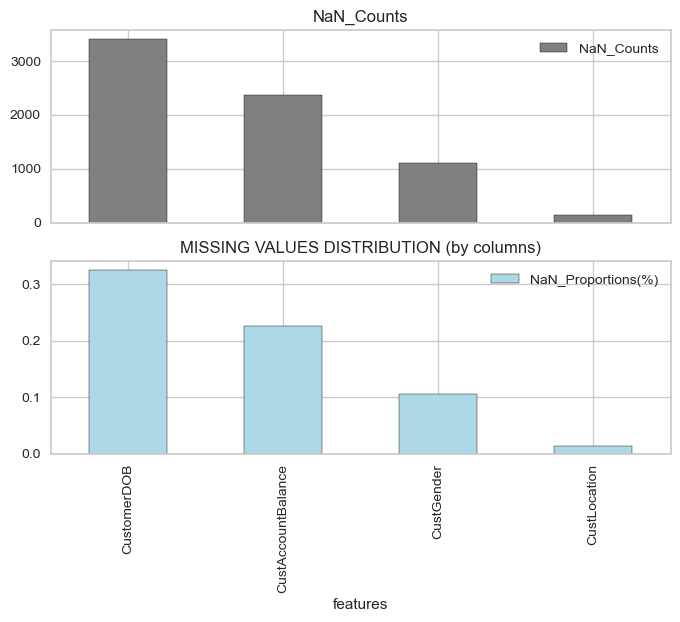

In [9]:
df.plot.bar(x="features", subplots=True,color=['gray','lightblue'],edgecolor='black')
plt.title('MISSING VALUES DISTRIBUTION (by columns)')

In [10]:
data.dropna(inplace=True) #remove missing values

In [11]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [12]:
data.describe() #quick summary of our data

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.041614e+06,1.041614e+06,1.041614e+06
mean,1.149986e+05,1.571221e+05,1.566096e+03
std,8.467609e+05,5.126352e+04,6.561464e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.728140e+03,1.240410e+05,1.600000e+02
50%,1.676852e+04,1.642470e+05,4.575000e+02
75%,5.742885e+04,2.000220e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [13]:
data.info() #we can observe that transaction date and DOB are in object format, let's covert those in time format

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.5+ MB


In [14]:
#let's trasform time variables in date time
data.CustomerDOB=pd.to_datetime(data.CustomerDOB) 
data.TransactionDate=pd.to_datetime(data.TransactionDate)
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

In [15]:
data.CustomerDOB.dt.year.value_counts()

1990    72616
1991    71185
1989    69156
1992    66484
1988    62905
        ...  
2020        2
2011        2
2016        2
2025        1
2018        1
Name: CustomerDOB, Length: 100, dtype: int64

In [16]:
#let's check the format of transaction date
data.TransactionTime.max() 
#probably this is hours/minutes/seconds

Timestamp('1900-01-01 23:59:59')

<AxesSubplot:>

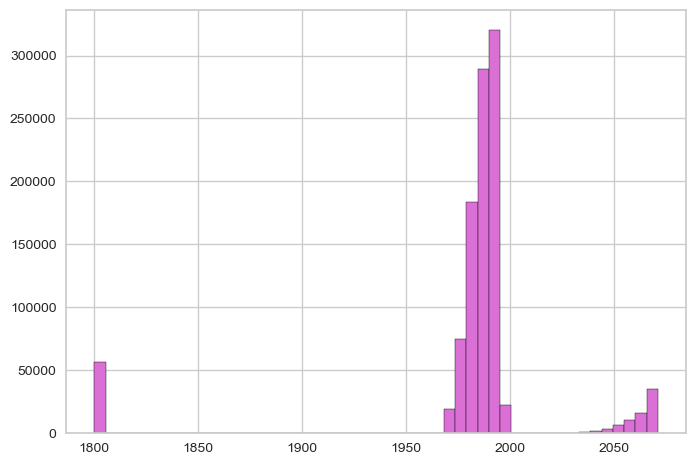

In [17]:
#visualize with an histogram the distribution of customers d.o.b.
data.CustomerDOB.dt.year.hist(bins=50,color='orchid',edgecolor='black')
#that's something strange. Probably this is a millenium bug after year 2000 (as we saw during the lab)

In [18]:
#We can drop customers who were born in 1800
data.drop(data[data.CustomerDOB.dt.year==1800].index,axis=0,inplace=True)

In [19]:
#we shift people born in 2050 back to 1950
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

<AxesSubplot:>

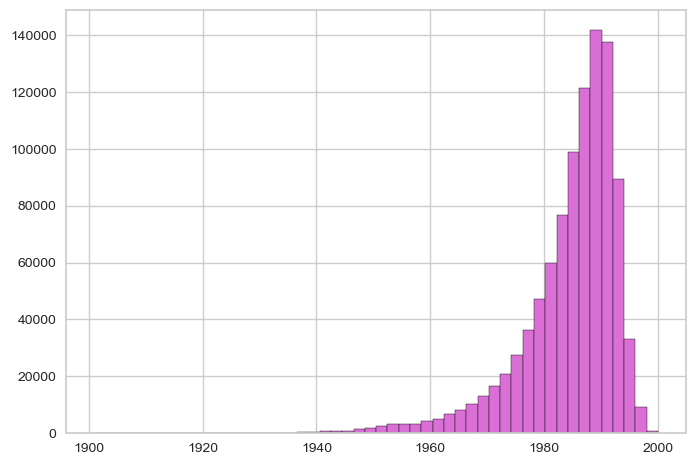

In [20]:
data.CustomerDOB.dt.year.hist(bins=50,color='orchid',edgecolor='black') #that distribution is clearly more realistic

In [21]:
data.head(5)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5


In [22]:
#a)Number of Transaction
#Let's extract the Number of Transaction by customer
NumTransaction=data.groupby('CustomerID',as_index=False).count()[['CustomerID','TransactionID']]
data_customer=NumTransaction.rename(columns={'TransactionID':'NumTransaction'})
data_customer

,CustomerID,NumTransaction
0,C1010011,2
1,C1010012,1
2,C1010014,2
3,C1010018,1
4,C1010024,1
...,...,...
839076,C9099836,1
839077,C9099877,1
839078,C9099919,1
839079,C9099941,1


In [23]:
data_customer['NumTransaction'].value_counts() #Display distribution on number of transactions

1    710185
2    113138
3     14291
4      1353
5       108
6         6
Name: NumTransaction, dtype: int64

In [24]:
from currency_converter import CurrencyConverter  #converter for currency conversion from rupees to usd $
from datetime import date
c = CurrencyConverter()
def convert(valueindia):
    dollar=c.convert(valueindia, 'INR', 'USD')
    return dollar
convert(100)

1.2248917459893558

In [25]:
#b) Number of transactions with a balance bigger than 100 USD
#as first let's build a function to convert rupees (INR) in dollars:
data['TransactionAmountUSD']=data['TransactionAmount (INR)'].map(convert).astype(int)
data['TransactionAmountUSD']

0            0
1          342
2            5
3           25
4           21
          ... 
1048562      9
1048563      5
1048564      9
1048565     12
1048566     14
Name: TransactionAmountUSD, Length: 985322, dtype: int32

In [26]:
#and let's converst also the balance for each account in order to have the same unit of currency
data['CustAccountBalanceUSD']=round(data['CustAccountBalance'].map(convert),2)
data['CustAccountBalanceUSD']

0            218.26
1             27.81
2            218.94
3          10613.73
4             82.24
             ...   
1048562       93.52
1048563      334.54
1048564     2716.28
1048565      123.93
1048566      927.66
Name: CustAccountBalanceUSD, Length: 985322, dtype: float64

In [27]:
#b) Number of transactions with a balance bigger than 100 USD
num_t_great100=data[data['CustAccountBalanceUSD']>100].groupby('CustomerID',as_index=False).count()[['CustomerID','TransactionID']]
num_t_great100=num_t_great100.rename(columns={'TransactionID':'Transactiongreat100'})
#merge with the dataset account specific
data_customer=pd.merge(data_customer,num_t_great100,on=['CustomerID'],how='left')

In [28]:
data_customer.fillna(0,inplace=True)

In [29]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100
0,C1010011,2,2.0
1,C1010012,1,1.0
2,C1010014,2,2.0
3,C1010018,1,0.0
4,C1010024,1,1.0
...,...,...,...
839076,C9099836,1,1.0
839077,C9099877,1,1.0
839078,C9099919,1,0.0
839079,C9099941,1,1.0


In [30]:
#c) Average amount of the transactions
avg=data.groupby('CustomerID',as_index=False).TransactionAmountUSD.mean()
avg=avg.rename(columns={'TransactionAmountUSD':'AVGTransactionUSD'})
data_customer=data_customer.merge(avg)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD
0,C1010011,2,2.0,31.0
1,C1010012,1,1.0,18.0
2,C1010014,2,2.0,8.5
3,C1010018,1,0.0,0.0
4,C1010024,1,1.0,61.0


In [31]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD
0,C1010011,2,2.0,31.0
1,C1010012,1,1.0,18.0
2,C1010014,2,2.0,8.5
3,C1010018,1,0.0,0.0
4,C1010024,1,1.0,61.0
...,...,...,...,...
839076,C9099836,1,1.0,8.0
839077,C9099877,1,1.0,2.0
839078,C9099919,1,0.0,1.0
839079,C9099941,1,1.0,0.0


In [32]:
#d) Average balance
balance=data.groupby('CustomerID',as_index=False).CustAccountBalance.mean()
balance=balance.rename(columns={'CustAccountBalance':'AVGBalance'})
data_customer=data_customer.merge(balance)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance
0,C1010011,2,2.0,31.0,76340.635
1,C1010012,1,1.0,18.0,24204.490
2,C1010014,2,2.0,8.5,100112.950
3,C1010018,1,0.0,0.0,496.180
4,C1010024,1,1.0,61.0,87058.650


In [33]:
#e) Average difference between the balance and the transaction amount for each customer 
data['Utilisation'] = data['CustAccountBalance'] - data['TransactionAmount (INR)']
Utilisation= data.groupby('CustomerID', as_index = False)[['CustomerID','Utilisation']].mean()
Utilisation=Utilisation.rename(columns={'Utilisation':'AVGUtilisation'})
Utilisation
data_customer=pd.merge(data_customer,Utilisation,on='CustomerID')
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635
1,C1010012,1,1.0,18.0,24204.490,22705.490
2,C1010014,2,2.0,8.5,100112.950,99385.450
3,C1010018,1,0.0,0.0,496.180,466.180
4,C1010024,1,1.0,61.0,87058.650,82058.650
...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230
839077,C9099877,1,1.0,2.0,96063.460,95841.460
839078,C9099919,1,0.0,1.0,5559.750,5433.750
839079,C9099941,1,1.0,0.0,35295.920,35245.920


In [34]:
#f) Most common gender of the customer and add column 'Comm_Gender' to 20 variables of the following question.
#trasform in 0-1
data['CustGender']=np.where(data['CustGender']=='M',0,1) #change labels for M and F to 0,1
gender=data.groupby('CustomerID',as_index=False).CustGender.mean() #we take the mean and create 3 labels: male,female, same gender in the account activity
gender['CustGender']=pd.cut(x=gender['CustGender'],bins=[-1,0.49,0.51,2],labels=[0,2,1])

#we can initialize values of the bins and assign to it some labels, the goal is 'categorise' from a continuous variable to a categorical variable
#the label 'samegender' means that in the specific one CustomerID there are both gender(male and female)
gender=gender.rename(columns={'CustGender':'Comm_Gender'})
data_customer=data_customer.merge(gender)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender
0,C1010011,2,2.0,31.0,76340.635,73787.635,2
1,C1010012,1,1.0,18.0,24204.490,22705.490,0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2
3,C1010018,1,0.0,0.0,496.180,466.180,1
4,C1010024,1,1.0,61.0,87058.650,82058.650,0


In [35]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender
0,C1010011,2,2.0,31.0,76340.635,73787.635,2
1,C1010012,1,1.0,18.0,24204.490,22705.490,0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2
3,C1010018,1,0.0,0.0,496.180,466.180,1
4,C1010024,1,1.0,61.0,87058.650,82058.650,0
...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0


In [36]:
male=data_customer[data_customer['Comm_Gender']==0].Comm_Gender.count()
female=data_customer[data_customer['Comm_Gender']==1].Comm_Gender.count()
same_gender=data_customer[data_customer['Comm_Gender']==2].Comm_Gender.count()
gender_common=male,female,same_gender #male are the most common customers of the bank
print('The bank have '+str(female)+' accounts managed by female customers, '+str(male)+' accounts managed by male customers and ' +str(same_gender)+' accounts managed by both gender people... we can assume that they are families or companies')

The bank have 208235 accounts managed by female customers, 585375 accounts managed by male customers and 45471 accounts managed by both gender people... we can assume that they are families or companies


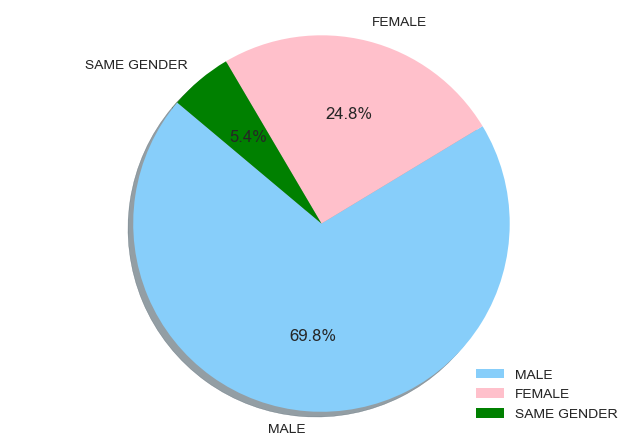

In [37]:
# Plot
labels='MALE','FEMALE','SAME GENDER'
explode = (0, 0,0)
colors = [  'lightskyblue','pink','green']
plt.pie(gender_common, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.legend( labels, loc='lower right')

plt.axis('equal')
plt.show()

In [38]:
#h) Most frequent location of the customer
datasupporto= data.sort_values(by='TransactionAmountUSD',ascending=False) #we take the place where the transaction is bigger(if there is more than one location by customerID)
datasupporto.drop_duplicates(subset='CustomerID',keep='first',inplace=True)


In [39]:
freq_loc_by_maxtrans=datasupporto.groupby(['CustomerID','CustLocation']).CustLocation.count()
freq_loc_by_maxtrans=pd.DataFrame(freq_loc_by_maxtrans)
df=freq_loc_by_maxtrans
df

,,CustLocation
CustomerID,CustLocation,
C1010011,NOIDA,1
C1010012,MUMBAI,1
C1010014,MUMBAI,1
C1010018,CHAMPARAN,1
C1010024,KOLKATA,1
...,...,...
C9099836,BHIWANDI,1
C9099877,BANGALORE,1
C9099919,GUNTUR,1


In [40]:
comm_df = pd.DataFrame(np.column_stack([df.index.get_level_values('CustLocation').tolist()]))
comm_df.columns = ['CommonLocation']
data_customer['CommonLocation']=comm_df['CommonLocation']
data_customer['CommonLocation'].head(5)

0        NOIDA
1       MUMBAI
2       MUMBAI
3    CHAMPARAN
4      KOLKATA
Name: CommonLocation, dtype: object

In [41]:
data_customer.head()

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,NOIDA
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,MUMBAI
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,MUMBAI
3,C1010018,1,0.0,0.0,496.180,466.180,1,CHAMPARAN
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,KOLKATA


In [42]:
#Trying to understand better our data...
#Extract the number of different places in the dataset
len(set(data_customer['CommonLocation'])) #8164 different places
#What are the places where customers,in general, make more transactions?
loc=data_customer.groupby('CommonLocation').NumTransaction.count().reset_index().sort_index()
toplocation=loc.sort_values(by='NumTransaction',ascending=False).head(10)

In [43]:
toplocation

,CommonLocation,NumTransaction
4508,MUMBAI,84622
654,BANGALORE,66198
4939,NEW DELHI,65612
2621,GURGAON,60408
1755,DELHI,57394
5021,NOIDA,26978
1374,CHENNAI,23527
5691,PUNE,20711
2878,HYDERABAD,18443
7108,THANE,17920


In [44]:
#Let's build a function to extract the population size in order to understand the relationship among the number of transactions 
#and the dimension of the city in terms of habitants. 
#a lower string (first letter in capital type) is needed in order to extract pop. size of the transaction locations
data_customer['CommonLocation'].str.lower()
data_customer['CommonLocation'] = data_customer['CommonLocation'].str.title()

def get_pop_size(city):
    query = """
    SELECT  ?population
    WHERE
    {
      ?city rdfs:label '%s'@en.
      ?city wdt:P1082 ?population.
      ?city wdt:P17 ?country.
      ?city rdfs:label ?cityLabel.
      ?country rdfs:label ?countryLabel.
      FILTER(LANG(?cityLabel) = "en").
      FILTER(LANG(?countryLabel) = "en").
      FILTER(CONTAINS(?countryLabel, "%s")).
    }
    """ % (city,'India')

    res = qwikidata.sparql.return_sparql_query_results(query)
    out = res['results']['bindings'][0]
    populationdict=out
    population = populationdict.get('population')
    
    return(population['value'])

In [45]:
#{please run this cell with internet connection}
#Ratio for Numbai:
ratio_Mumbai= round(int(toplocation["NumTransaction"].iloc[0])/int(get_pop_size('Mumbai'))*100,5)
print('The  '+str(ratio_Mumbai) +' % of people in Mumbai makes transaction for our Axis Bank' )   #not very loud

ratio_Bangalore=round(int(toplocation["NumTransaction"].iloc[0])/int(get_pop_size('Bangalore'))*100,5)
print('The  '+str(ratio_Bangalore) +' % of people in Bangalore makes transaction for our Axis Bank' )

ratio_NEWDELHI=round(int(toplocation["NumTransaction"].iloc[0])/int(get_pop_size('New Delhi'))*100,5)
print('The  '+str(ratio_NEWDELHI) +' % of people in New Delhi makes transaction for our Axis Bank' )

The  0.54898 % of people in Mumbai makes transaction for our Axis Bank
The  0.68648 % of people in Bangalore makes transaction for our Axis Bank
The  33.84907 % of people in New Delhi makes transaction for our Axis Bank


In [46]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata
...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai


3. Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

_Hints for feature engineering:_

In [47]:
# Let's extract the age of our customer, we create a 'support column' to use with the groupby
data['CAge'] = ((pd.to_datetime('today')-data.CustomerDOB)/np.timedelta64(1,'Y'))
data['CAge'] = data['CAge'].astype(int)
data['CAge']

0          28
1          65
2          26
3          49
4          34
           ..
1048562    32
1048563    30
1048564    33
1048565    44
1048566    38
Name: CAge, Length: 985322, dtype: int32

In [48]:
#1)Age of our customers grouped by Customer Id, taking the mode
data_customer= data_customer.merge(data[['CustomerID','CAge']], on='CustomerID') 
data_customer= data_customer.drop_duplicates(subset=['CustomerID']).rename(columns={'CAge':'CustomerAge'}) #drop duplicates

In [49]:
data_customer['CustomerAge']=data_customer['CustomerAge'].astype(int)

Text(0.5, 1.0, 'Distribution of customers Age')

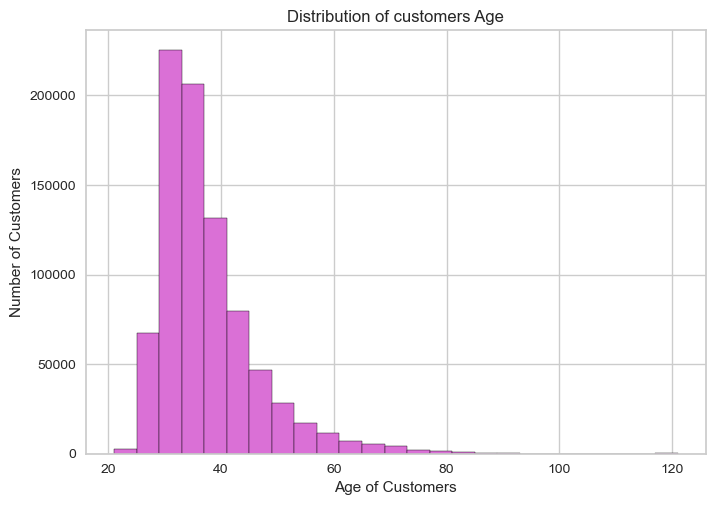

In [50]:
#plot
data_customer.CustomerAge.plot(kind='hist',bins=25,color='orchid',edgecolor='black')
plt.xlabel("Age of Customers")
plt.ylabel('Number of Customers')
plt.title('Distribution of customers Age')

In [51]:
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30
2,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28
3,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30
5,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32
6,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57


In [52]:
#2) Minimum transaction amount for each customer
Min_Transaction=data[['CustomerID','TransactionAmount (INR)']].groupby('CustomerID',as_index=False).min()
Min_Transaction=Min_Transaction.rename(columns={'TransactionAmount (INR)':'Min_TransactionINR'})
Min_Transaction
data_customer=pd.merge(data_customer,Min_Transaction,on='CustomerID') 
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0
...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0


In [53]:
#3) Maximum transaction amount for each customer
Max_Transaction=data[['CustomerID','TransactionAmount (INR)']].groupby('CustomerID',as_index=False).max()
Max_Transaction=Max_Transaction.rename(columns={'TransactionAmount (INR)':'Max_TransactionINR'})
Max_Transaction
data_customer=pd.merge(data_customer,Max_Transaction,on='CustomerID') 
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0


In [54]:
#4) Mean of Transaction by Customer
Mean_Transaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].mean()
Mean_Transaction=Mean_Transaction.rename(columns={'TransactionAmount (INR)':'Mean_TransactionINR'})
Mean_Transaction
data_customer=pd.merge(data_customer,Mean_Transaction,on='CustomerID') 
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0


In [55]:
#5) Quartiles Q1
Q1_Transaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.25)
Q1_Transaction=Q1_Transaction.rename(columns={'TransactionAmount (INR)':'Q1_Transaction'})
Q1_Transaction
data_customer=pd.merge(data_customer,Q1_Transaction,on='CustomerID') 
data_customer

C:\Users\Admin\AppData\Local\Temp\ipykernel_15304\309134330.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  Q1_Transaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.25)


,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00


In [56]:
#6) Quartiles Q3
Q3_Transaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.75)
Q3_Transaction=Q3_Transaction.rename(columns={'TransactionAmount (INR)':'Q3_Transaction'})
Q3_Transaction
data_customer=pd.merge(data_customer,Q3_Transaction,on='CustomerID') 
data_customer

C:\Users\Admin\AppData\Local\Temp\ipykernel_15304\1254831950.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  Q3_Transaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.75)


,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00


In [57]:
#7) Median Transaction
MedianTransaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.5)
MedianTransaction=MedianTransaction.rename(columns={'TransactionAmount (INR)':'MedianTransaction'})
MedianTransaction
data_customer=pd.merge(data_customer,MedianTransaction,on='CustomerID') 
data_customer

C:\Users\Admin\AppData\Local\Temp\ipykernel_15304\2817124337.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  MedianTransaction=data.groupby('CustomerID',as_index=False)[['CustomerID','TransactionAmount (INR)']].quantile(0.5)


,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00,691.0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00,222.0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00,126.0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00,50.0


In [58]:
#8) Percentage of customer deposits to the bank's total reserves (we work on USD curreny change in order to have numbers more readable)
total_reserveUSD=data_customer['AVGBalance'].sum() #we compute an approximation of the reserve of the bank by the avg balance
cust_bal=data_customer.groupby('CustomerID',as_index=False)['AVGBalance'].sum()
cust_bal=cust_bal.set_index('CustomerID')
percentage_amount=pd.DataFrame(((cust_bal['AVGBalance'])/(total_reserveUSD))*100).reset_index()
percentage_amount=percentage_amount.rename(columns={'AVGBalance':'PercentageAmount'})
percentage_amount=round(percentage_amount,6)

In [59]:
data_customer=pd.merge(data_customer,percentage_amount,on='CustomerID')
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00,691.0,0.000150
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00,222.0,0.000108
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00,126.0,0.000006
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00,50.0,0.000040


In [60]:
total_reserveUSD=round(total_reserveUSD,2)#total reserve of the bank based on the deposit of customers (not the whole reserves of tha bank!)
print(str(total_reserveUSD)+' $')

88820532790.49 $


In [61]:
set(sorted(round(data_customer['PercentageAmount'],5),reverse=True)[:35]) #display the customer with the bigger part of bank reserve(current reserve) ... probably those are companys with more Customer Id
#This is important because we can observe that the first six have a very concentrated percentage of wealth in their accounts 
#compared to the rest of the customers. Surely the bank must treat these customers in a special way

{0.05742, 0.06476, 0.06485, 0.07858, 0.0926, 0.12952}

In [62]:
data_customer.head(3)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113


In [63]:
#9) Labels: Let's label customers by balance account: Premium customers, silver and basic. Also young label is useful for customers with age less than 30years.
#Those type of labels are useful for marketing advertising, for instance... Who will be interest on promotion about mortgage?
data2=data.groupby('CustomerID').sum()
labels=pd.DataFrame(pd.cut(x=data2['CustAccountBalanceUSD'],bins=[0,1000,10000,1000000000],labels=['Basic','Silver','Premium']))
labels=labels.rename({'CustAccountBalanceUSD': 'CustCategory'}, axis=1)
data_customer=pd.merge(data_customer,labels,on='CustomerID')

In [64]:
data_customer.head(10)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver
5,C1010028,1,1.0,6.0,296828.370,296271.370,1,Delhi,34,557.0,557.0,557.0,557.00,557.00,557.0,0.000334,Silver
6,C1010031,2,1.0,10.5,5200.155,4268.155,0,Trichy,38,404.0,1460.0,932.0,668.00,1196.00,932.0,0.000006,Basic
7,C1010035,2,1.0,4.0,192648.755,192273.755,0,Navi Mumbai,30,50.0,700.0,375.0,212.50,537.50,375.0,0.000217,Silver
8,C1010036,1,1.0,2.0,355430.170,355222.170,0,Gurgaon,26,208.0,208.0,208.0,208.00,208.00,208.0,0.000400,Silver
9,C1010037,1,1.0,241.0,95859.170,76179.170,0,Bangalore,41,19680.0,19680.0,19680.0,19680.00,19680.00,19680.0,0.000108,Silver


In [65]:
#10) Let's split our customers by age
data_customer['CustGeneration']=pd.cut(x=data_customer.CustomerAge,bins=[0,30,60,120],labels=['Young','Adult','Elderly'])
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver,Young
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic,Adult
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00,691.0,0.000150,Silver,Adult
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00,222.0,0.000108,Silver,Young
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00,126.0,0.000006,Basic,Young
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00,50.0,0.000040,Basic,Young


In [66]:
#11) Bank Account Solvence: Passive(negative balance) or Active(Positive balance)
data['CustSolvence']=np.where(data['Utilisation']>0,'Active','Passive')
data_customer['CustSolvence']=data['CustSolvence']
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver,Young,Active
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic,Adult,Active
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00,691.0,0.000150,Silver,Adult,Active
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00,222.0,0.000108,Silver,Young,Active
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00,126.0,0.000006,Basic,Young,Active
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00,50.0,0.000040,Basic,Young,Passive


In [67]:
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver,Young,Active
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic,Adult,Active
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active


In [68]:
data_customer['CustSolvence'].value_counts()

Active     709340
Passive     78707
Name: CustSolvence, dtype: int64

In [69]:
passive=data_customer[data_customer['CustSolvence']=='Passive'].CustSolvence.count()#big part of the customer are insolvent.
print('The bank have '+str(passive)+' passive account')

The bank have 78707 passive account


In [70]:
active=len(data_customer)-passive
percentage_insolvence=(passive/len(data))*100
percentage_insolvence #something near the 8% of the customers have a bank account in red...not a good news for
#the Manager of tha bank! This is a big ratio.

7.987947087348095

In [71]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver,Young,Active
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic,Adult,Active
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,691.0,691.0,691.00,691.00,691.0,0.000150,Silver,Adult,Active
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,222.0,222.0,222.00,222.00,222.0,0.000108,Silver,Young,Active
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,126.0,126.0,126.00,126.00,126.0,0.000006,Basic,Young,Active
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,50.0,50.0,50.00,50.00,50.0,0.000040,Basic,Young,Passive


In [72]:
#12) Having a child means big changes (also financial changes), knowing whether 
#a woman is old enough to have children can be useful in creating a customised plan 
data_customer.groupby('CustomerID',as_index=False).head()
data_customer['ChildBearing_Age']='NA'
data_customer.loc[(data_customer['CustomerAge']<=47) & (data_customer['Comm_Gender']==1),'ChildBearing_Age']=1
data_customer.loc[(data_customer['Comm_Gender']==0),'ChildBearing_Age']=0
data_customer.loc[(data_customer['Comm_Gender']==2),'ChildBearing_Age']=0
data_customer.loc[(data_customer['CustomerAge']>47) & (data_customer['Comm_Gender']==1),'ChildBearing_Age']=0
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,4750.0,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active,0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,1499.0,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive,0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,1205.0,727.5,488.75,966.25,727.5,0.000113,Silver,Young,Active,0
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,30.0,30.0,30.00,30.00,30.0,0.000001,Basic,Adult,Active,1
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,5000.0,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active,0


In [73]:
#13) transaction day in the week
data['TransactionDay'] = data['TransactionDate'].dt.dayofweek
data['TransactionDay']
#select first value by positions by Series.iat
TransactionDay= data.groupby('CustomerID', as_index = False)['TransactionDay'].apply(lambda x: x.mode().iat[0]) 
TransactionDay

,CustomerID,TransactionDay
0,C1010011,0
1,C1010012,6
2,C1010014,4
3,C1010018,3
4,C1010024,3
...,...,...
839076,C9099836,4
839077,C9099877,3
839078,C9099919,3
839079,C9099941,6


In [74]:
data_customer = data_customer.merge(TransactionDay)
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,Mean_TransactionINR,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,2553.0,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active,0,0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,1499.0,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive,0,6
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,727.5,488.75,966.25,727.5,0.000113,Silver,Young,Active,0,4
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,30.0,30.00,30.00,30.0,0.000001,Basic,Adult,Active,1,3
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,5000.0,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,...,691.0,691.00,691.00,691.0,0.000150,Silver,Adult,Active,0,4
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,...,222.0,222.00,222.00,222.0,0.000108,Silver,Young,Active,0,3
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,...,126.0,126.00,126.00,126.0,0.000006,Basic,Young,Active,0,3
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,...,50.0,50.00,50.00,50.0,0.000040,Basic,Young,Passive,0,6


In [75]:
#14) Transaction in the Month
data['TransactionMonth'] = data['TransactionDate'].dt.month
TransactionMonth= data.groupby('CustomerID')['TransactionMonth'].apply(lambda x: x.value_counts().index[0]).reset_index() 
TransactionMonth

,CustomerID,TransactionMonth
0,C1010011,9
1,C1010012,8
2,C1010014,1
3,C1010018,9
4,C1010024,8
...,...,...
839076,C9099836,7
839077,C9099877,9
839078,C9099919,8
839079,C9099941,8


In [76]:
data_customer = data_customer.merge(TransactionMonth)
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,Q1_Transaction,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,1454.50,3651.50,2553.0,0.000086,Silver,Young,Active,0,0,9
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,1499.00,1499.00,1499.0,0.000027,Basic,Young,Passive,0,6,8
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,488.75,966.25,727.5,0.000113,Silver,Young,Active,0,4,1
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,30.00,30.00,30.0,0.000001,Basic,Adult,Active,1,3,9
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,5000.00,5000.00,5000.0,0.000098,Silver,Adult,Active,0,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,...,691.00,691.00,691.0,0.000150,Silver,Adult,Active,0,4,7
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,...,222.00,222.00,222.0,0.000108,Silver,Young,Active,0,3,9
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,...,126.00,126.00,126.0,0.000006,Basic,Young,Active,0,3,8
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,...,50.00,50.00,50.0,0.000040,Basic,Young,Passive,0,6,8


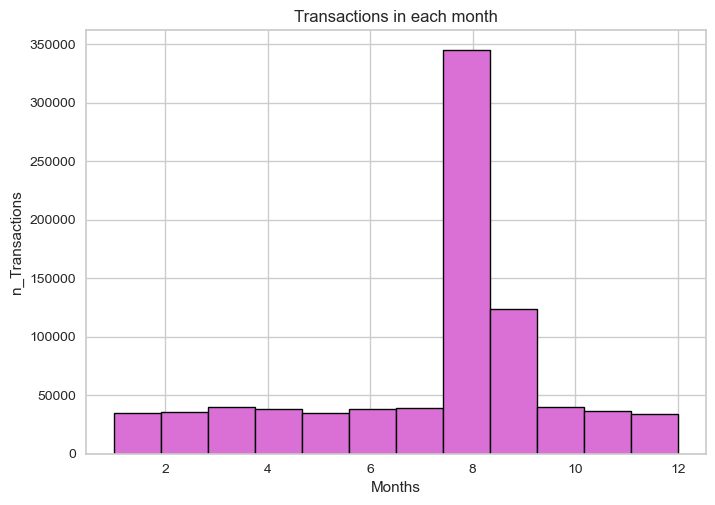

In [77]:
plt.hist(data_customer['TransactionMonth'], color='orchid', edgecolor='black',bins = 12, linewidth=1)
plt.title('Transactions in each month')
plt.xlabel('Months')
plt.ylabel('n_Transactions')
plt.show()
#There is a peak in August, probably due to the period when people ,usually, go on holiday!

In [78]:
#15) Transaction hour 
data['TransactionHour'] = data['TransactionTime'].dt.hour
TransactionHour= data.groupby('CustomerID',as_index=False)['TransactionHour'].apply(lambda x: x.value_counts().index[0]) 
TransactionHour
data_customer = data_customer.merge(TransactionHour)
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,Q3_Transaction,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,3651.50,2553.0,0.000086,Silver,Young,Active,0,0,9,12
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,1499.00,1499.0,0.000027,Basic,Young,Passive,0,6,8,20
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,966.25,727.5,0.000113,Silver,Young,Active,0,4,1,15
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,30.00,30.0,0.000001,Basic,Adult,Active,1,3,9,17
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,5000.00,5000.0,0.000098,Silver,Adult,Active,0,3,8,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,...,691.00,691.0,0.000150,Silver,Adult,Active,0,4,7,0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,...,222.00,222.0,0.000108,Silver,Young,Active,0,3,9,12
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,...,126.00,126.0,0.000006,Basic,Young,Active,0,3,8,12
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,...,50.00,50.0,0.000040,Basic,Young,Passive,0,6,8,21


Text(0.5, 1.0, 'Hour of the Transaction')

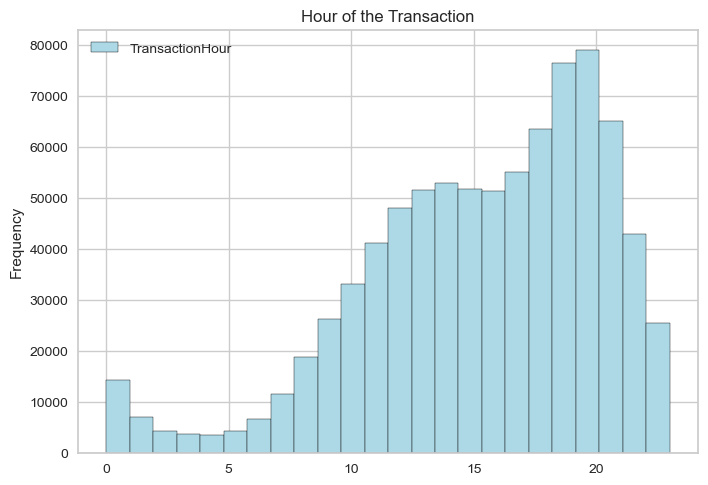

In [79]:
pd.DataFrame(data_customer['TransactionHour']).plot(bins=24,kind='hist',color='lightblue',edgecolor='black')
plt.title('Hour of the Transaction')

In [80]:
#16) Max Utilisation
MaxUtilisation = data[['CustomerID','Utilisation']].groupby('CustomerID',as_index=False).max()
MaxUtilisation=MaxUtilisation.rename(columns={'Utilisation':'MaxUtilisation'}) 
MaxUtilisation
data_customer = data_customer.merge(MaxUtilisation)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,MedianTransaction,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,2553.0,0.000086,Silver,Young,Active,0,0,9,12,119824.54
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,1499.0,0.000027,Basic,Young,Passive,0,6,8,20,22705.49
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,727.5,0.000113,Silver,Young,Active,0,4,1,15,161598.76
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,30.0,0.000001,Basic,Adult,Active,1,3,9,17,466.18
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,5000.0,0.000098,Silver,Adult,Active,0,3,8,14,82058.65


In [81]:
#17) Min Utilisation
MinUtilisation = data[['CustomerID','Utilisation']].groupby('CustomerID').min().reset_index()
MinUtilisation=MinUtilisation.rename(columns={'Utilisation':'MinUtilisation'}) 
MinUtilisation
data_customer = data_customer.merge(MinUtilisation)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,PercentageAmount,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,0.000086,Silver,Young,Active,0,0,9,12,119824.54,27750.73
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,0.000027,Basic,Young,Passive,0,6,8,20,22705.49,22705.49
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,0.000113,Silver,Young,Active,0,4,1,15,161598.76,37172.14
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,0.000001,Basic,Adult,Active,1,3,9,17,466.18,466.18
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,0.000098,Silver,Adult,Active,0,3,8,14,82058.65,82058.65


In [82]:
#18) Quartile 1 of Utilisation
Q1Utilisation = data[['CustomerID','Utilisation']].groupby('CustomerID').quantile(0.25).reset_index()
Q1Utilisation=Q1Utilisation.rename(columns={'Utilisation':'Q1Utilisation'}) 
Q1Utilisation
data_customer = data_customer.merge(Q1Utilisation)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,CustCategory,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,Silver,Young,Active,0,0,9,12,119824.54,27750.73,50769.1825
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,Basic,Young,Passive,0,6,8,20,22705.49,22705.49,22705.4900
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,Silver,Young,Active,0,4,1,15,161598.76,37172.14,68278.7950
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,Basic,Adult,Active,1,3,9,17,466.18,466.18,466.1800
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,Silver,Adult,Active,0,3,8,14,82058.65,82058.65,82058.6500


In [83]:
#19) Quartile 3 of Utilisation
Q3Utilisation = data[['CustomerID','Utilisation']].groupby('CustomerID').quantile(0.75).reset_index()
Q3Utilisation=Q3Utilisation.rename(columns={'Utilisation':'Q3Utilisation'}) 
Q3Utilisation
data_customer = data_customer.merge(Q3Utilisation)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,CustGeneration,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation,Q3Utilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,Young,Active,0,0,9,12,119824.54,27750.73,50769.1825,96806.0875
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,Young,Passive,0,6,8,20,22705.49,22705.49,22705.4900,22705.4900
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,Young,Active,0,4,1,15,161598.76,37172.14,68278.7950,130492.1050
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,Adult,Active,1,3,9,17,466.18,466.18,466.1800,466.1800
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,Adult,Active,0,3,8,14,82058.65,82058.65,82058.6500,82058.6500


In [84]:
#20) Median of Utilisation
MedianUtilisation = data[['CustomerID','Utilisation']].groupby('CustomerID').median().reset_index()
MedianUtilisation=MedianUtilisation.rename(columns={'Utilisation':'MedianUtilisation'}) 
MedianUtilisation
data_customer = data_customer.merge(MedianUtilisation)
data_customer.head(5)

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation,Q3Utilisation,MedianUtilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,Active,0,0,9,12,119824.54,27750.73,50769.1825,96806.0875,73787.635
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,Passive,0,6,8,20,22705.49,22705.49,22705.4900,22705.4900,22705.490
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,Active,0,4,1,15,161598.76,37172.14,68278.7950,130492.1050,99385.450
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,Active,1,3,9,17,466.18,466.18,466.1800,466.1800,466.180
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,Active,0,3,8,14,82058.65,82058.65,82058.6500,82058.6500,82058.650


In [85]:
data_customer

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,CustSolvence,ChildBearing_Age,TransactionDay,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation,Q3Utilisation,MedianUtilisation
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,Active,0,0,9,12,119824.54,27750.73,50769.1825,96806.0875,73787.635
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,Passive,0,6,8,20,22705.49,22705.49,22705.4900,22705.4900,22705.490
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,Active,0,4,1,15,161598.76,37172.14,68278.7950,130492.1050,99385.450
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,Active,1,3,9,17,466.18,466.18,466.1800,466.1800,466.180
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,Active,0,3,8,14,82058.65,82058.65,82058.6500,82058.6500,82058.650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,...,Active,0,4,7,0,132376.23,132376.23,132376.2300,132376.2300,132376.230
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,...,Active,0,3,9,12,95841.46,95841.46,95841.4600,95841.4600,95841.460
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,...,Active,0,3,8,12,5433.75,5433.75,5433.7500,5433.7500,5433.750
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,...,Passive,0,6,8,21,35245.92,35245.92,35245.9200,35245.9200,35245.920


***

#### 2.2 Choose your features (variables)!
As you may notice, you have plenty of features to work with now. So, you need to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1. To normalise or not to normalise? That's the question. Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

2. Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

















- In order to reduce the size of our dataset, we will use the Principal Component Analysis method:
PCA is a technique for feature extraction and it is used to extract the important information from a multivariate dataset and to express this information as a set of few new variables called principal components. These new variables correspond to a linear combination of the originals. The number of principal components is less than the number of original variables.

The information in a given data set corresponds to the total variation it contains. The goal of PCA is to identify directions (or principal components) **along which the variation in the data is maximal**.

A limitation of using PCA is that it only performs on quantitative variables and not on categorical ones. We will later try to avoid this problem by constructing dummy variables on categorical variables.

- TRASFORM THE DATA

In order to perform PCA we have to standardize our dataset. Stardardization( translating and scaling our features so that they are all distributed around a mean of zero with a standard deviation of one) is required because PCA is very sensitive to the variance of the original variables in the dataset.The reason is that, if **there are features with big differences in their initial unit of measures then the features with a higher range of values will overstress the overall analysis** and PCA will be more biased towards those features. So performing standardization initially can prevent this from happening.

Standardization is done by using the following formula:
$$
Z=\frac{X-\mu}{\sigma}
$$








3. Apply the selected method(s) to your data. Ensure the chosen method retains > 70% of the total variance.

***

In [86]:
data_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839081 entries, 0 to 839080
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   CustomerID           839081 non-null  object  
 1   NumTransaction       839081 non-null  int64   
 2   Transactiongreat100  839081 non-null  float64 
 3   AVGTransactionUSD    839081 non-null  float64 
 4   AVGBalance           839081 non-null  float64 
 5   AVGUtilisation       839081 non-null  float64 
 6   Comm_Gender          839081 non-null  category
 7   CommonLocation       839081 non-null  object  
 8   CustomerAge          839081 non-null  int32   
 9   Min_TransactionINR   839081 non-null  float64 
 10  Max_TransactionINR   839081 non-null  float64 
 11  Mean_TransactionINR  839081 non-null  float64 
 12  Q1_Transaction       839081 non-null  float64 
 13  Q3_Transaction       839081 non-null  float64 
 14  MedianTransaction    839081 non-null  float64 
 15  

In [87]:
#We want to use the gender variable in our dimensionality reduction process. Let's trasfrom this variable in quantitative one.
dummies = pd.get_dummies(data_customer['Comm_Gender'],drop_first=False)  
data_dummy= pd.concat([data_customer,dummies],axis=1)
data_dummy

,CustomerID,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CommonLocation,CustomerAge,Min_TransactionINR,...,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation,Q3Utilisation,MedianUtilisation,0,2,1
0,C1010011,2,2.0,31.0,76340.635,73787.635,2,Noida,30,356.0,...,9,12,119824.54,27750.73,50769.1825,96806.0875,73787.635,0,1,0
1,C1010012,1,1.0,18.0,24204.490,22705.490,0,Mumbai,28,1499.0,...,8,20,22705.49,22705.49,22705.4900,22705.4900,22705.490,1,0,0
2,C1010014,2,2.0,8.5,100112.950,99385.450,2,Mumbai,30,250.0,...,1,15,161598.76,37172.14,68278.7950,130492.1050,99385.450,0,1,0
3,C1010018,1,0.0,0.0,496.180,466.180,1,Champaran,32,30.0,...,9,17,466.18,466.18,466.1800,466.1800,466.180,0,0,1
4,C1010024,1,1.0,61.0,87058.650,82058.650,0,Kolkata,57,5000.0,...,8,14,82058.65,82058.65,82058.6500,82058.6500,82058.650,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839076,C9099836,1,1.0,8.0,133067.230,132376.230,0,Bhiwandi,31,691.0,...,7,0,132376.23,132376.23,132376.2300,132376.2300,132376.230,1,0,0
839077,C9099877,1,1.0,2.0,96063.460,95841.460,0,Bangalore,26,222.0,...,9,12,95841.46,95841.46,95841.4600,95841.4600,95841.460,1,0,0
839078,C9099919,1,0.0,1.0,5559.750,5433.750,0,Guntur,29,126.0,...,8,12,5433.75,5433.75,5433.7500,5433.7500,5433.750,1,0,0
839079,C9099941,1,1.0,0.0,35295.920,35245.920,0,Chennai,27,50.0,...,8,21,35245.92,35245.92,35245.9200,35245.9200,35245.920,1,0,0


In [88]:
#Let's remove categorical features 
data_quant=data_dummy.drop(['CustSolvence', 'CustGeneration','CustCategory','CommonLocation','CustomerID'], axis=1)

In [89]:
data_quant.head(10)

,NumTransaction,Transactiongreat100,AVGTransactionUSD,AVGBalance,AVGUtilisation,Comm_Gender,CustomerAge,Min_TransactionINR,Max_TransactionINR,Mean_TransactionINR,...,TransactionMonth,TransactionHour,MaxUtilisation,MinUtilisation,Q1Utilisation,Q3Utilisation,MedianUtilisation,0,2,1
0,2,2.0,31.0,76340.635,73787.635,2,30,356.0,4750.0,2553.0,...,9,12,119824.54,27750.73,50769.1825,96806.0875,73787.635,0,1,0
1,1,1.0,18.0,24204.490,22705.490,0,28,1499.0,1499.0,1499.0,...,8,20,22705.49,22705.49,22705.4900,22705.4900,22705.490,1,0,0
2,2,2.0,8.5,100112.950,99385.450,2,30,250.0,1205.0,727.5,...,1,15,161598.76,37172.14,68278.7950,130492.1050,99385.450,0,1,0
3,1,0.0,0.0,496.180,466.180,1,32,30.0,30.0,30.0,...,9,17,466.18,466.18,466.1800,466.1800,466.180,0,0,1
4,1,1.0,61.0,87058.650,82058.650,0,57,5000.0,5000.0,5000.0,...,8,14,82058.65,82058.65,82058.6500,82058.6500,82058.650,1,0,0
5,1,1.0,6.0,296828.370,296271.370,1,34,557.0,557.0,557.0,...,8,9,296271.37,296271.37,296271.3700,296271.3700,296271.370,0,0,1
6,2,1.0,10.5,5200.155,4268.155,0,38,404.0,1460.0,932.0,...,3,11,7186.21,1350.10,2809.1275,5727.1825,4268.155,1,0,0
7,2,1.0,4.0,192648.755,192273.755,0,30,50.0,700.0,375.0,...,1,11,377313.09,7234.42,99754.0875,284793.4225,192273.755,1,0,0
8,1,1.0,2.0,355430.170,355222.170,0,26,208.0,208.0,208.0,...,8,9,355222.17,355222.17,355222.1700,355222.1700,355222.170,1,0,0
9,1,1.0,241.0,95859.170,76179.170,0,41,19680.0,19680.0,19680.0,...,9,16,76179.17,76179.17,76179.1700,76179.1700,76179.170,1,0,0


In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_stand=scaler.fit_transform(data_quant)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [91]:
data_stand=pd.DataFrame(data_stand)
type(data_stand)

pandas.core.frame.DataFrame

In [92]:
#Let's fit PCA
pca = PCA().fit(data_stand)

In [93]:
#display the percentage of total variance explained by each principal component#
print(pca.explained_variance_ratio_)

[3.06133892e-01 2.58860948e-01 1.34089549e-01 8.16729593e-02
 4.04444352e-02 3.91169957e-02 3.82501483e-02 3.57676269e-02
 3.35177689e-02 1.66713020e-02 6.89028715e-03 5.13942488e-03
 2.89259336e-03 2.91311968e-04 2.39491183e-04 1.61855715e-05
 4.30271907e-06 4.19996013e-07 1.78045251e-07 1.56549876e-07
 1.31183297e-08 8.00608645e-09 2.42725449e-09 1.52629964e-29
 7.45709248e-32 5.49540389e-32]


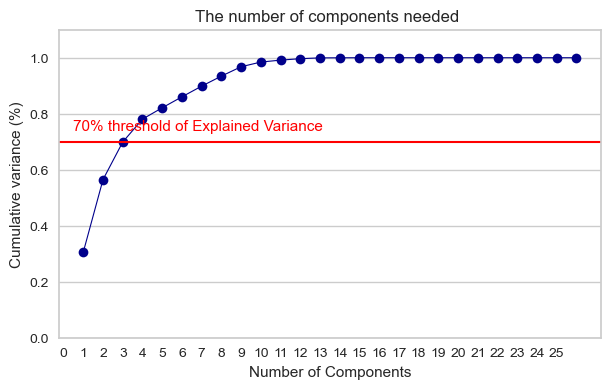

In [94]:
#Let's show how the explained Variance change as Number of components change
plt.rcParams["figure.figsize"] = (7,4)
fig, ax = plt.subplots()
xi = np.arange(1, 27, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='darkblue',linewidth=0.8)

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 26, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed ')

plt.axhline(y=0.70, color='red', linestyle='-',linewidth=1.5)
plt.text(0.5, 0.74, '70% threshold of Explained Variance', color = 'red', fontsize=11)

ax.grid(axis='x')
plt.show()

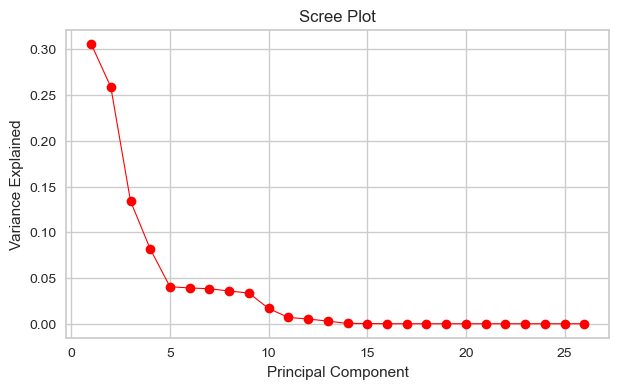

In [95]:
#Scree Plot
PC = np.arange(pca.n_components_) + 1
plt.plot(PC, pca.explained_variance_ratio_, 'o-', linewidth=0.8, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [96]:
#The two plots above show us that the 'optimal' number of principal component 
pca__ = PCA(n_components=4)
principalComponents = pca__.fit_transform(data_stand)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2',
                                      'principal component 3', 'principal component 4'])

In [97]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4
0,0.093212,0.517687,-2.828046,5.142976
1,-0.302155,0.079182,1.183229,-0.415610
2,-0.072920,-0.235861,-2.823994,4.855803
3,-0.645669,-0.437648,-2.865427,-1.799649
4,0.562751,1.514476,1.344353,0.162625
...,...,...,...,...
839076,-0.028472,-0.391094,1.246242,-0.150211
839077,-0.247380,-0.544999,1.161885,-0.131626
839078,-0.609174,-0.493052,1.316210,-0.768420
839079,-0.468173,-0.531897,1.163352,-0.416972


In [97]:
principalDf.to_csv('DF_PCA.csv')

In [98]:
#Let's display the explained variance by each component
print(pca__.explained_variance_ratio_)

[0.30613389 0.25886095 0.13408955 0.08167296]


C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


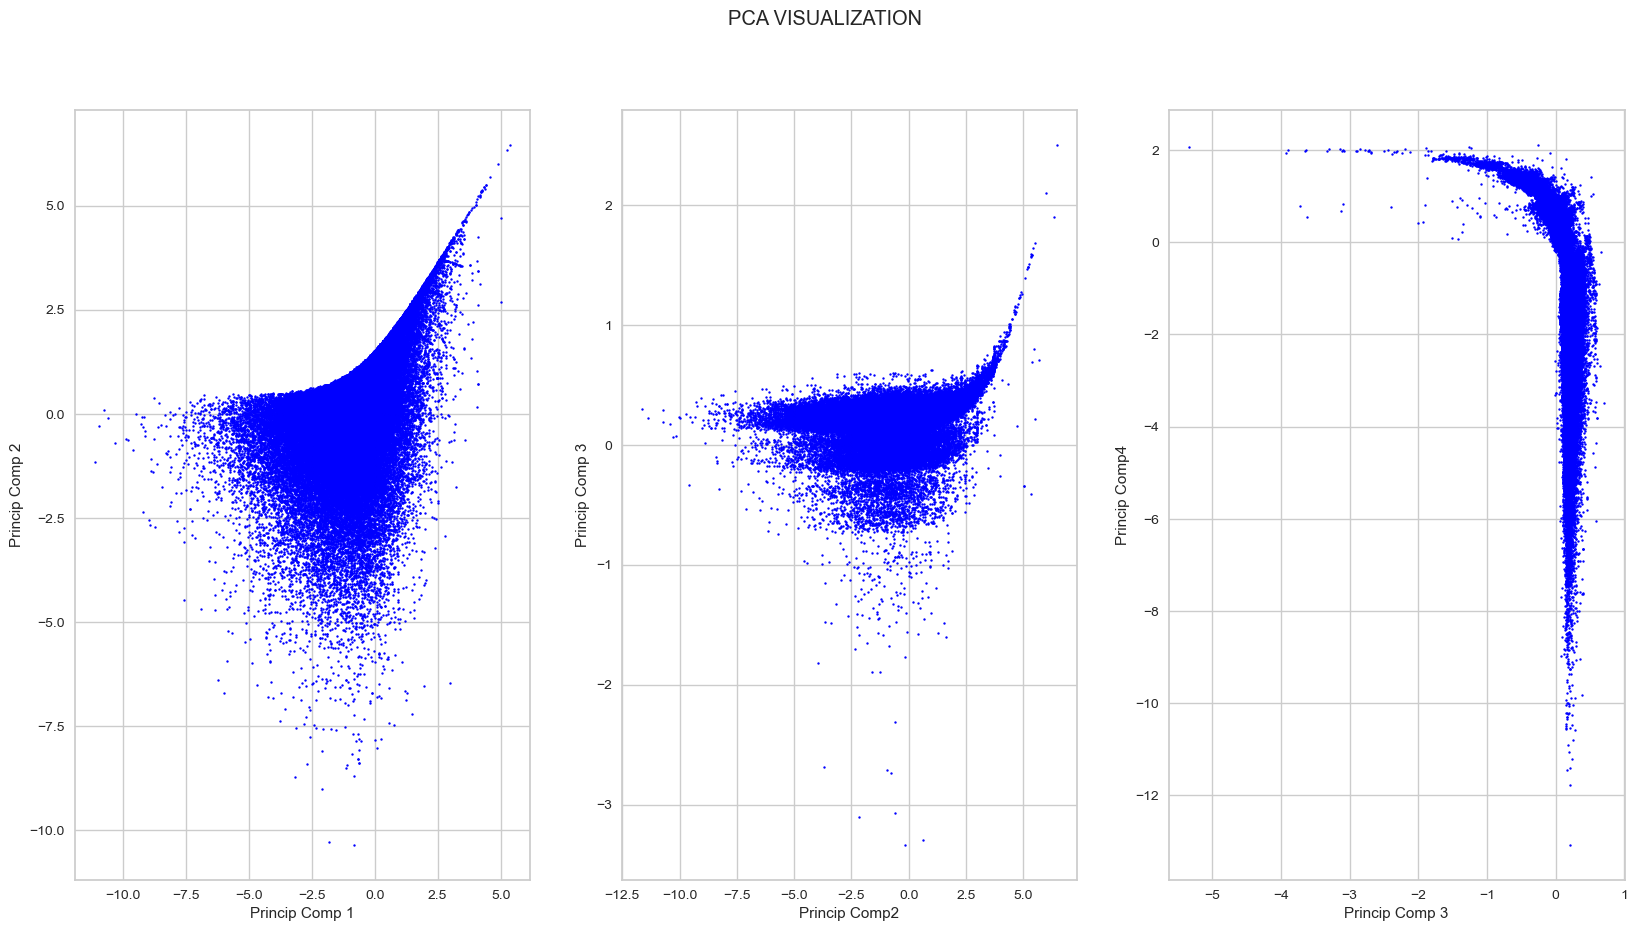

In [99]:
#Let's visualize the shape  components
fig, (ax1, ax2,ax3)  = plt.subplots(ncols=3,figsize=(20,10))
fig.suptitle('PCA VISUALIZATION')
#ax.set_title('A single plot')
x1=np.log(principalDf['principal component 1'])
y1=np.log(principalDf['principal component 2'])
ax1.scatter(x1, y1, s=1.8,color='blue')


x2=np.log(principalDf['principal component 2'])
y2=np.log(principalDf['principal component 3'])
ax2.scatter(x2, y2, s=1.8,color='blue')



x3=np.log(principalDf['principal component 3'])
y3=np.log(principalDf['principal component 4'])
ax3.scatter(x3, y3, s=1.8,color='blue')


ax1.set(xlabel="Princip Comp 1",ylabel="Princip Comp 2")
ax2.set(xlabel="Princip Comp2",ylabel="Princip Comp 3")
ax3.set(xlabel="Princip Comp 3",ylabel="Princip Comp4")

plt.show()

***

#### 2.3 Clustering!

1. Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! We also ask you to use MapReduce in your K-means algorithm.

***

As a first step we import PySpark and create the working environment:

In [ ]:
!pip install pyspark

In [23]:
import pyspark
from pyspark.sql import SparkSession

In [25]:
spark = SparkSession.builder.appName('kmeans').getOrCreate()
spark

In [26]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=kmeans>

Let's now define two functions that will be used for the actual algorithm

In [27]:
def assign_cluster(x, centroids):
    distances = []
    for centroid in centroids:
        distances.append(np.linalg.norm(np.array(x) - np.array(centroid)))
    return (np.argmin(distances), (np.array(x), 1))

In [28]:
def compute_loss(y, centroid):
    loss = np.linalg.norm(np.array(y[1][0])-np.array(centroid[y[0]]))
    return loss

__Implementation__ \
As a stopping condition (in addition to the maximum iteration) the algorithm calculates the sum of the distances of each point from its centroid, if from one iteration to another the difference of this sum is less than $\epsilon$ the algorithm stops.

In [29]:
def kmeansPS(X, k, eps=0.001):
    # maximum number of iterations allowed
    max_iter = 100
    # loss_history initialization
    loss_history = []
    # randomly chosing the initial centroids
    centroids = X.rdd.takeSample(False, k)
    # repeating the mapping and reducing until convergence or until reaching the max_iter
    for iteration in range(max_iter):
        # creating the cluster
        cluster = X.rdd.map(lambda x: assign_cluster(x, centroids)).collect()
        # creating rdd object
        cluster_rdd = sc.parallelize(cluster)
        # computing the new centroids
        centroids = cluster_rdd.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
            .map(lambda x: x[1][0]/x[1][1]).collect()
        # evaluating the distances of every element from their centroid
        loss = cluster_rdd.map(lambda x: (x[0], compute_loss(x, centroids)))\
                .groupByKey().mapValues(sum).values().collect()
        # summing all the distances in order the use that value as loss
        loss_history.append(np.sum(loss))
        if iteration > 0:
            if loss_history[iteration-1]-loss_history[iteration] < eps:
                break
    return cluster_rdd.keys().collect(), iteration, loss_history[:-1]

***

2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

***

In [68]:
df_pca = pd.read_csv('DF_PCA.csv', usecols=['principal component 1', 'principal component 2',
                                            'principal component 3', 'principal component 4'])
df_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4
0,0.093247,0.517693,-2.828018,5.142994
1,-0.302120,0.079188,1.183246,-0.415589
2,-0.072885,-0.235853,-2.823963,4.855833
3,-0.645638,-0.437641,-2.865409,-1.799603
4,0.562777,1.514507,1.344398,0.162736


In [ ]:
model = KMeans()

- __First method: Elbow method__ \
It's a heuristic method used in determining the number of clusters in a data set. It consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use.

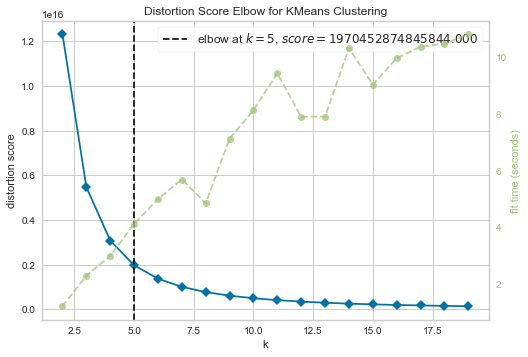

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer.fit(df_pca)
visualizer.show()

- __Second method: Silhouette Coefficient__ \
It's a method of interpretation and validation of consistency within clusters of data. We will have a graphical representation of how well each object has been classified. The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. \
$$ S(i) = \frac{b(i)-a(i)}{max\{a(i),b(i)\}} $$
where: \
$\implies b(i)$ is the smallest average distance of point i to all points in any other cluster \
$\implies a(i)$ is the average distance of i from all other points in its cluster \
__Note:__ _For this method and the third one we will use only a sample of the dataset as it is computationally very expensive. The result will therefore be an approximation but by randomly choosing rows from the dataset we should be able to maintain the cluster structure and therefore obtain a satisfactory output._

In [3]:
df_pca_sub = df_pca.sample(n=100000)

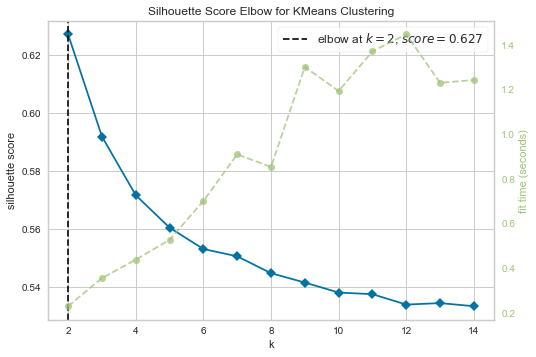

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings= True)
visualizer.fit(df_pca_sub)
visualizer.show()

- __Third method: Calinski-Harabasz Index__ \
It's also called the variance ratio criterion (VRC). The idea is that well-defined clusters have a large between-cluster variance and a small within-cluster variance so the optimal number of clusters corresponds to the solution with the highest Calinski-Harabasz index value.
$$ CH(k) = \frac{B(k)}{W(k)} \cdot \frac{n-k}{k-1} $$
where: \
$\implies B(k)=$ between cluster variation \
$\implies W(k)=$ within cluster variation \
$\implies n=$ # data point \
$\implies k=$ # clusters

In [19]:
plt.rcParams["figure.figsize"] = (10,8)

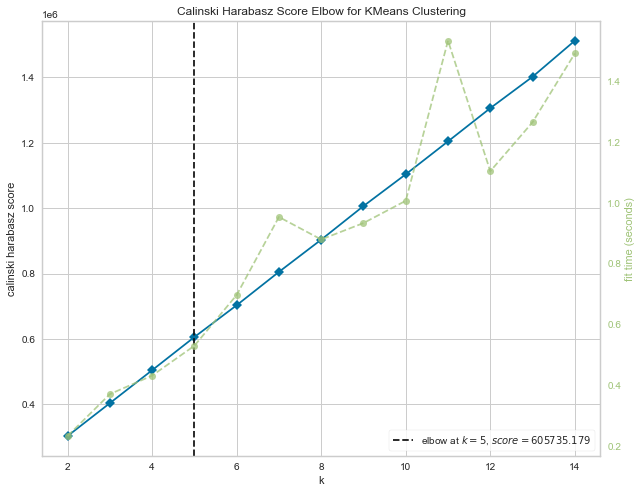

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [21]:
visualizer = KElbowVisualizer(model, k=(2,15), metric='calinski_harabasz', timings= True)
visualizer.fit(df_pca_sub)
visualizer.show()

- __Fourth method: Davies-Bouldin Index__ \
It captures both the separation and compactness of the clusters. This is due to the fact that the measure’s ‘max’ statement repeatedly selects the values where the average point is farthest away from its center, and where the centers are closest together. As DB index falls, the clustering improves.
$$ DB= \frac{1}{n} \sum_{i=1}^n \text{max}_{j \neq i} \bigg( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \bigg)$$

In [16]:
from sklearn.metrics import davies_bouldin_score

# function found online
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    return score

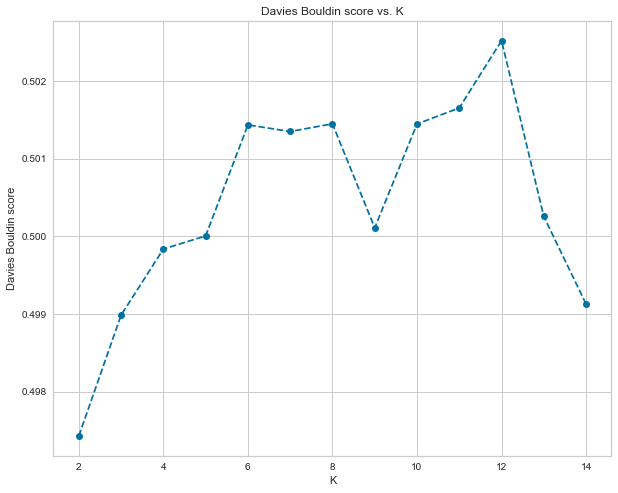

In [22]:
scores = []
centers = list(range(2,15))
for center in centers:
    scores.append(get_kmeans_score(df_pca_sub, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

After evaluating the outputs of the 4 implemented methods, we decided to choose k=5. The choice was dictated by the fact that 2 of the 4 implemented methods (including the '_Elbow Method_') suggested this number, which compared with the k=2 of the other methods seemed more appropriate to better discriminate our units.

In [36]:
k = 5

***

3. Run the algorithm on the data.

***

Let's first upload the dataset with PySpark:

In [33]:
df_spark = spark.read.csv('DF_PCA.csv', header=True, inferSchema=True)
df_spark = df_spark.select(['principal component 1', 'principal component 2',
                            'principal component 3', 'principal component 4'])
df_spark = df_spark.withColumnRenamed('principal component 1', 'PC1')
df_spark = df_spark.withColumnRenamed('principal component 2', 'PC2')
df_spark = df_spark.withColumnRenamed('principal component 3', 'PC3')
df_spark = df_spark.withColumnRenamed('principal component 4', 'PC4')
df_spark.printSchema()
df_spark.show(5)
df_spark.describe().show()

root
 |-- PC1: double (nullable = true)
 |-- PC2: double (nullable = true)
 |-- PC3: double (nullable = true)
 |-- PC4: double (nullable = true)

+--------------------+--------------------+-------------------+-------------------+
|                 PC1|                 PC2|                PC3|                PC4|
+--------------------+--------------------+-------------------+-------------------+
| 0.09324714423209401|   0.517693341576607| -2.828018023276199|  5.142993720195219|
| -0.3021197691816084|  0.0791876022443233|  1.183245634810002|-0.4155886431438997|
|-0.07288465849659267|-0.23585314055690207|-2.8239627962081504|  4.855833154369339|
| -0.6456377138066474|-0.43764072323284825|-2.8654088617797284| -1.799602604961617|
|  0.5627771358254298|  1.5145073344012252|  1.344397932406357|0.16273559650195515|
+--------------------+--------------------+-------------------+-------------------+
only showing top 5 rows



+-------+--------------------+--------------------+--------------------+--------------------+
|summary|                 PC1|                 PC2|                 PC3|                 PC4|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|              839081|              839081|              839081|              839081|
|   mean|-2.24912911408889...|-5.51443102068783...|-1.03886731820943...|-3.27885087716574...|
| stddev|  2.8212564189754388|   2.594300475001689|  1.8671728640112228|   1.457225331631105|
|    min| -0.7010832173375698| -131.71323610472967|  -5.036474999959094| -10.602257291466843|
|    max|  390.78613195734795|   640.5827949774764|   12.20359251518706|  11.670308052632263|
+-------+--------------------+--------------------+--------------------+--------------------+



And now let's run our kmeans:

In [105]:
start_time_kmeansPS = time.time()
labelsPS, iterations, loss_history = kmeansPS(df_spark, k, eps=0.01)
final_time_kmeansPS = round(time.time() - start_time_kmeansPS, 3)
print("--- %s seconds ---" % final_time_kmeansPS)

--- 303.526 seconds ---


In [48]:
iterations

2

In [50]:
loss_history

[3392620.5051703965, 2115658.415350829]

In [71]:
df_pca['labelsPS'] = labelsPS

In [72]:
df_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4,labelsPS
0,0.093247,0.517693,-2.828018,5.142994,0
1,-0.302120,0.079188,1.183246,-0.415589,3
2,-0.072885,-0.235853,-2.823963,4.855833,0
3,-0.645638,-0.437641,-2.865409,-1.799603,4
4,0.562777,1.514507,1.344398,0.162736,2


***

4. Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

***

In [106]:
start_time_kmeans = time.time()
kmeans = KMeans(n_clusters=k, init='k-means++').fit(df_pca[['principal component 1', 'principal component 2',
                            'principal component 3', 'principal component 4']])
labelsKmeans = kmeans.labels_
final_time_kmeans = round(time.time() - start_time_kmeans, 3)
print("--- %s seconds ---" % final_time_kmeans)

--- 3.553 seconds ---


In [100]:
df_pca['labelsKmeans++'] = labelsKmeans
with open("df_kmeans.pkl", "wb") as file:
    pickle.dump(df_pca, file)
df_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4,labelsPS,labelsKmeans++
0,0.093247,0.517693,-2.828018,5.142994,0,3
1,-0.302120,0.079188,1.183246,-0.415589,3,0
2,-0.072885,-0.235853,-2.823963,4.855833,0,3
3,-0.645638,-0.437641,-2.865409,-1.799603,4,1
4,0.562777,1.514507,1.344398,0.162736,2,0


In [101]:
for i in range(k):
    print(f'kmeansSpark | #cluster{i}: {np.sum(df_pca["labelsPS"]==i)}')
    print(f'kmeans++ | #cluster{i}: {np.sum(df_pca["labelsKmeans++"]==i)}')

kmeansSpark | #cluster0: 57350
kmeans++ | #cluster0: 574664
kmeansSpark | #cluster1: 32604
kmeans++ | #cluster1: 204574
kmeansSpark | #cluster2: 245517
kmeans++ | #cluster2: 117
kmeansSpark | #cluster3: 303611
kmeans++ | #cluster3: 56802
kmeansSpark | #cluster4: 199999
kmeans++ | #cluster4: 2924


Let's compute the _adjusted_rand_score_, it computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings

In [103]:
print(f'Classification similarity: {round(adjusted_rand_score(df_pca["labelsPS"], df_pca["labelsKmeans++"]),3)*100}%')

Classification similarity: 50.4%


Through the adjusted rand score we can see that the kmeans implemented by us and the kmeans++ present in the sklearn library have classified 50% of the data in the same way and that the kmeans++ tends to create smaller clusters than those of our algorithm. 

Comparing the times we can also see how kmeans++ is much faster, this is caused not only by our non-optimal implementation of the algorithm but also by the fact that we are not exploiting the potential of PySpark and MapReduce as we cannot run the algorithm in parallel on multiple machines.

In [108]:
print("Our kmeans: %s seconds" % final_time_kmeansPS)
print("kmeans++: %s seconds" % final_time_kmeans)

Our kmeans: 303.526 seconds
kmeans++: 3.553 seconds


In [133]:
with open("df_kmeans.pkl", "rb") as file:
    df_kmeans = pickle.load(file)
df_kmeans_sub = df_kmeans.sample(n=10000)

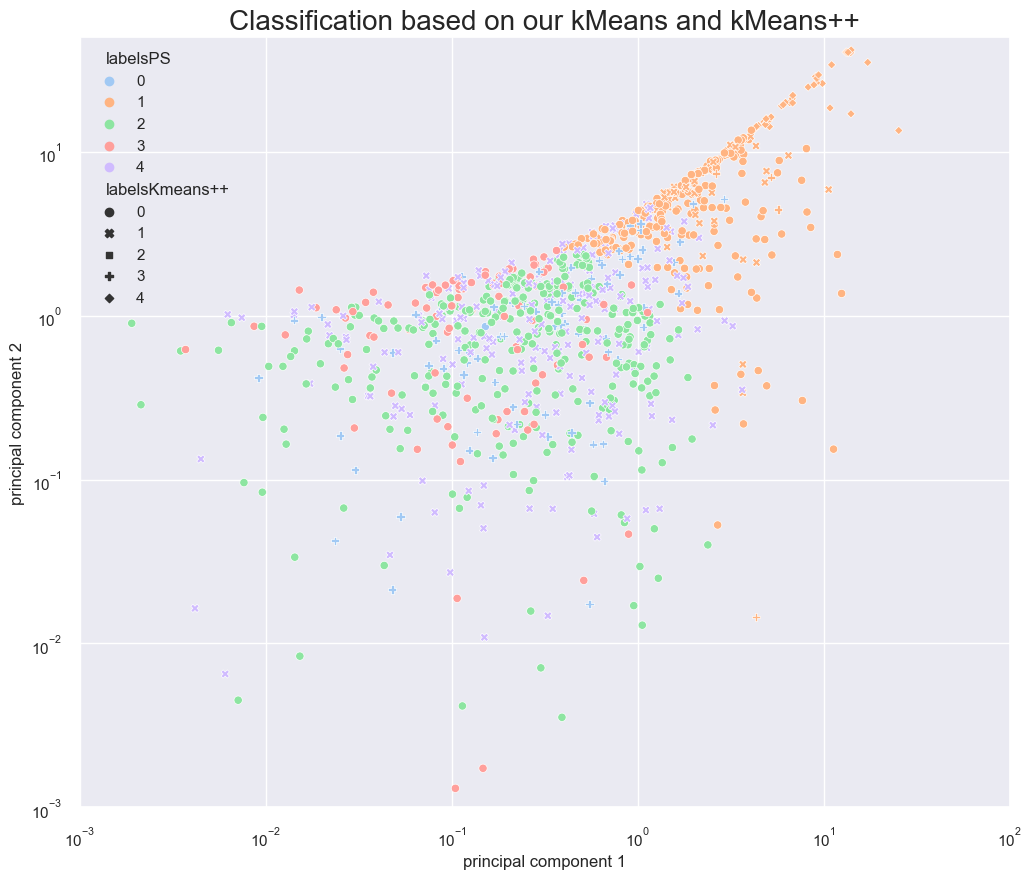

In [134]:
plt.rcParams["figure.figsize"] = (12, 10)
plot = sns.scatterplot(data=df_kmeans_sub, x="principal component 1", y="principal component 2",
                hue="labelsPS", style="labelsKmeans++", palette="pastel")
plot.axes.set_title("Classification based on our kMeans and kMeans++", fontsize=20)
plot.set_xlim(0.001, 100)
plot.set_ylim(0.001, 50)
plot.set(xscale="log", yscale="log")
plt.show()

***

#### 2.4 Analysing your results!

You are often encouraged to explain the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:

1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.

2. Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

3. With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100. The sample example for clustering with K = 4 and Gender variable:

5. Interpret the results for each pivot table.

6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

#### IMPORTANT NOTE:

- We know you may consult the internet for information about implementing the requested algorithms. However, the final code must be yours! So please, do not search and copy-paste the code.

- Since we know that some of the previous points can raise many questions, opening a thread on Slack is recommended and welcomed.

- Unfortunately, there are no explicit descriptions of the features in the data sets. Nevertheless, the names are usually self-explanatory. In case you have any doubt, Google will help you better understand the characteristics of a bank's customer.

In [102]:
data.to_pickle('bank.pkl') #save in the pickle format
principalDf.to_pickle('principaldata.pkl')
data_customer.to_pickle('data_customer.pkl')

In [103]:
data = pd.read_pickle('bank.pkl') #and read it ,both 'big' dataset and the pca dataset
principalDf =pd.read_pickle('principaldata.pkl')
data_customer=pd.read_pickle('data_customer.pkl')

In [104]:
#Let's select our relevant variables
relevant= data_customer[['CustomerID','CustomerAge','Comm_Gender','CustCategory','AVGBalance']].groupby('CustomerID').last()
#this new dataframe have 3 quantitative variables and one categorical (category of the customers based on the quantitative variables selected)

In [105]:
relevant

,CustomerAge,Comm_Gender,CustCategory,AVGBalance
CustomerID,,,,
C1010011,30,2,Silver,76340.635
C1010012,28,0,Basic,24204.490
C1010014,30,2,Silver,100112.950
C1010018,32,1,Basic,496.180
C1010024,57,0,Silver,87058.650
...,...,...,...,...
C9099836,31,0,Silver,133067.230
C9099877,26,0,Silver,96063.460
C9099919,29,0,Basic,5559.750


In [106]:
relevant['CustCategoryAge']=pd.cut(relevant['CustomerAge'],bins=[0,30,45,60,120],labels=['Young','Adult','Senior','Retired'])
relevant.head(5)

,CustomerAge,Comm_Gender,CustCategory,AVGBalance,CustCategoryAge
CustomerID,,,,,
C1010011,30,2,Silver,76340.635,Young
C1010012,28,0,Basic,24204.490,Young
C1010014,30,2,Silver,100112.950,Young
C1010018,32,1,Basic,496.180,Adult
C1010024,57,0,Silver,87058.650,Senior


In [107]:
#STANDARDIZE and create a new dataframe (relevant_stand) ready for clustering. We
#have to use 2 dataframes(one standardized and one not) because labeled columns like cust-category and age-Category are based on original values of customer-age and customer balance columns.
import scipy
from scipy import stats
relevant_stand=pd.DataFrame()
relevant_stand['CustomerAge'] = stats.zscore(relevant['CustomerAge'])
relevant_stand['AVGBalance']=stats.zscore(relevant['CustomerAge'])
relevant_stand['Comm_Gender']=relevant['Comm_Gender']
relevant_stand.head(5)

,CustomerAge,AVGBalance,Comm_Gender
CustomerID,,,
C1010011,-0.785132,-0.785132,2
C1010012,-1.008091,-1.008091,0
C1010014,-0.785132,-0.785132,2
C1010018,-0.562173,-0.562173,1
C1010024,2.224811,2.224811,0


In [108]:
for k in tqdm(range(3,8)):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(relevant_stand[['CustomerAge','Comm_Gender','AVGBalance']])
    relevant_stand[f'Clusters{k}']=kmeans.labels_

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.73s/it]


In [109]:
relevant_stand

,CustomerAge,AVGBalance,Comm_Gender,Clusters3,Clusters4,Clusters5,Clusters6,Clusters7
CustomerID,,,,,,,,
C1010011,-0.785132,-0.785132,2,0,2,0,4,3
C1010012,-1.008091,-1.008091,0,0,0,1,0,2
C1010014,-0.785132,-0.785132,2,0,2,0,4,3
C1010018,-0.562173,-0.562173,1,0,2,0,4,3
C1010024,2.224811,2.224811,0,1,1,4,5,5
...,...,...,...,...,...,...,...,...
C9099836,-0.673653,-0.673653,0,0,0,1,0,2
C9099877,-1.231049,-1.231049,0,0,0,1,0,2
C9099919,-0.896611,-0.896611,0,0,0,1,0,2


In [110]:
#perform the elbow method
def kmeans_elbow(data,max_k):
    means=[]
    inertias=[]
    
    for k in range(1,max_k):
        kmeans=KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig=plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

In [111]:
#let'use a sample of the dataset for the elbow metod
relevant_sample=relevant_stand.sample(100000)
relevant_sample=relevant_sample.reset_index()
sample_=relevant_sample[['CustomerAge','AVGBalance','Comm_Gender']]
sample_
#visualizer.fit(relevant[['CustomerAge','CustAccountBalanceUSD','Comm_Gender']])# Fit the data to the visualizer, here CustBalance is the same that cust category but in a quantitative way 
#visualizer.show()        # Finalize and render the figure

,CustomerAge,AVGBalance,Comm_Gender
0,0.552620,0.552620,1
1,0.106703,0.106703,0
2,-1.231049,-1.231049,0
3,-0.896611,-0.896611,0
4,0.106703,0.106703,0
...,...,...,...
99995,-0.227735,-0.227735,0
99996,0.775579,0.775579,1
99997,1.110017,1.110017,0
99998,-1.454008,-1.454008,1


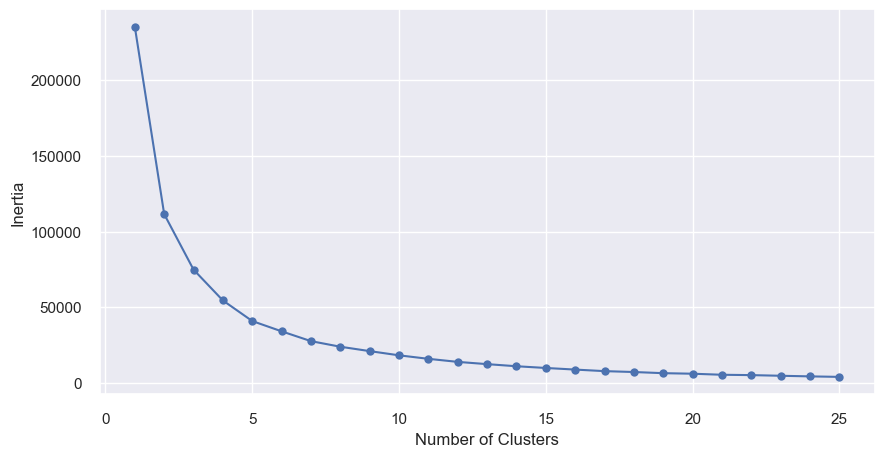

In [112]:
kmeans_elbow(sample_,26)

In [113]:
relevant_stand.head(5)

,CustomerAge,AVGBalance,Comm_Gender,Clusters3,Clusters4,Clusters5,Clusters6,Clusters7
CustomerID,,,,,,,,
C1010011,-0.785132,-0.785132,2,0,2,0,4,3
C1010012,-1.008091,-1.008091,0,0,0,1,0,2
C1010014,-0.785132,-0.785132,2,0,2,0,4,3
C1010018,-0.562173,-0.562173,1,0,2,0,4,3
C1010024,2.224811,2.224811,0,1,1,4,5,5


In [114]:
relevant=pd.merge(relevant,relevant_stand['Clusters5'], left_index=True, right_index=True,how='outer') 
relevant=pd.merge(relevant,relevant_stand['Clusters6'], left_index=True, right_index=True,how='outer') 
relevant.head(5)

,CustomerAge,Comm_Gender,CustCategory,AVGBalance,CustCategoryAge,Clusters5,Clusters6
CustomerID,,,,,,,
C1010011,30,2,Silver,76340.635,Young,0,4
C1010012,28,0,Basic,24204.490,Young,1,0
C1010014,30,2,Silver,100112.950,Young,0,4
C1010018,32,1,Basic,496.180,Adult,0,4
C1010024,57,0,Silver,87058.650,Senior,4,5


In [115]:
relevant['Clusters5'].value_counts()

0    271224
2    256263
3    180793
1    105787
4     25014
Name: Clusters5, dtype: int64

In [ ]:
#Let's display our data points with 5 clusters. In the first plot we check the balance and the age of the customers.

In [ ]:
plt.rcParams["figure.figsize"] = (12, 10)
plot = sns.scatterplot(data=relevant_stand, x='CustomerAge', y='AVGBalance',
                hue="labelsPS", style="labelsKmeans++", palette="pastel")
plot.axes.set_title("Age and AVGBalance with 5 clusters", fontsize=20)
plot.set_xlim(0.001, 100)
plot.set_ylim(0.001, 50)
plot.set(xscale="log", yscale="log")
plt.show()

In [116]:
table = relevant.pivot_table(index=['Clusters5'],columns='CustCategory',aggfunc='count').Comm_Gender
table1 = table.div(table.sum(axis=1), axis=0)
table1

CustCategory,Basic,Silver,Premium
Clusters5,,,
0,0.870897,0.119508,0.009595
1,0.624736,0.314540,0.060724
2,0.758564,0.213822,0.027614
3,0.792136,0.194888,0.012976
4,0.547127,0.354292,0.098581


- TABLE1) From the first pivot table based on Customer Category we can obser that each cluster is quite heterogeneous in terms of customer classes. Thus, this variable is not significant for the identification of a cluster, roughly speaking there is a slight variation of customer class in each cluster with the premium class always less frequent than the others.

<AxesSubplot:xlabel='Clusters5'>

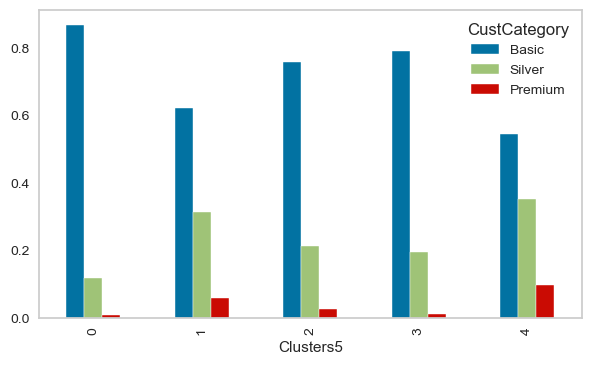

In [117]:
table1.plot(kind='bar')

In [118]:
table = relevant.pivot_table(index=['Clusters5'],columns='Comm_Gender',aggfunc='count').CustCategory
table

Comm_Gender,0,2,1
Clusters5,,,
0,270257,0,0
1,72765,6178,26484
2,223353,0,32131
3,0,37896,142510
4,16897,1397,6437


In [119]:
table2 = table.div(table.sum(axis=1), axis=0)
table2

Comm_Gender,0,2,1
Clusters5,,,
0,1.000000,0.000000,0.000000
1,0.690193,0.058600,0.251207
2,0.874235,0.000000,0.125765
3,0.000000,0.210060,0.789940
4,0.683232,0.056488,0.260281


- TABLE2) From the pivot table above, we can see how 'common gender' tells us something more than custcategory. Cluster number #3 groups only male customers and cluster #0 groups only female customers and accounts managed by both genders. Note that there are no clusters where accounts predominate 
managed by both genders.

<AxesSubplot:xlabel='Clusters5'>

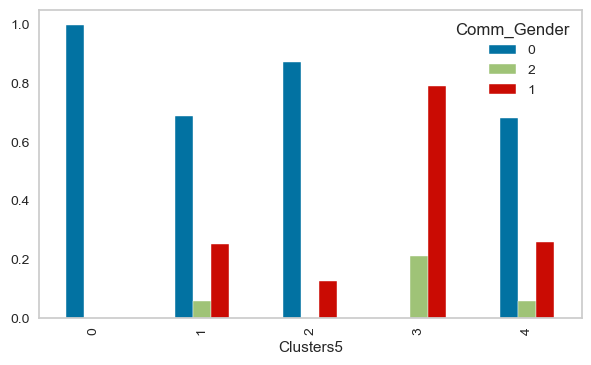

In [120]:
table2.plot(kind='bar')

In [121]:
table = relevant.pivot_table(index=['Clusters5'],columns='CustCategoryAge',aggfunc='count').CustomerAge
table

CustCategoryAge,Young,Adult,Senior,Retired
Clusters5,,,,
0,113847,157377,0,0
1,0,18619,87168,0
2,0,256263,0,0
3,58642,122151,0,0
4,0,0,2563,22332


In [122]:
table3 = table.div(table.sum(axis=1), axis=0)
table3

CustCategoryAge,Young,Adult,Senior,Retired
Clusters5,,,,
0,0.419753,0.580247,0.000000,0.000000
1,0.000000,0.176005,0.823995,0.000000
2,0.000000,1.000000,0.000000,0.000000
3,0.324360,0.675640,0.000000,0.000000
4,0.000000,0.000000,0.102952,0.897048


- TABLE3) From table 3 we see that gender is the most informative variable as clusters characterised by customers in certain age groups are created. For example, cluster number 1 exclusively groups adult customers, number 2 has a prevalence of retired customers. It should also be noted that youths and adults (age range between 20 and 40) characterise the same clusters.

<AxesSubplot:xlabel='Clusters5'>

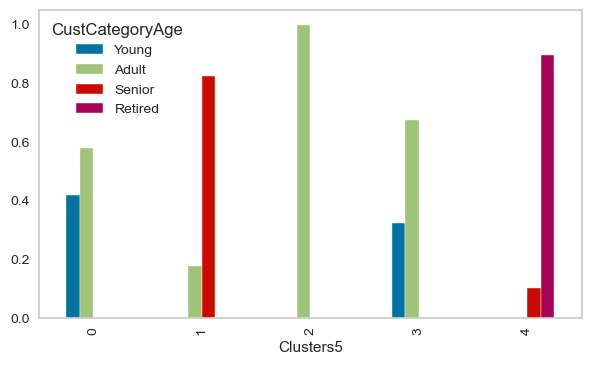

In [123]:
table3.plot(kind='bar')

In [124]:
sample_.head()

,CustomerAge,AVGBalance,Comm_Gender
0,-0.339022,-0.339022,0
1,-0.673477,-0.673477,0
2,0.106917,0.106917,0
3,-0.896447,-0.896447,1
4,0.218402,0.218402,1


Basically a good clustering will have close distances between objects in the same cluster and objects that are far apart to not be grouped togheter.

Silhouette score is a tool to measure how similar an object to its own cluster compared to other clusters.
- **Silhouette** plot is used to estimate algorithm performance and visualize how well the data point belongs to the cluster. Silhouette score measures how similar an object to its own cluster compared to other clusters.


$$S=\frac{b-a}{\max (a, b)}$$

where:

**a** is the averaged distance among Centroid 1 and its data points;

**b** is the averaged distance among Centroid1 and data points that belongs to other Centroids.

In order to standardize the quantity *'S'* we divide by the maximum value of a and b, i.e. the colest data point to the Centroids they belongs to.

The large score refers to the point that well belongs to the cluster,i.e. which are closer to its centroid. 

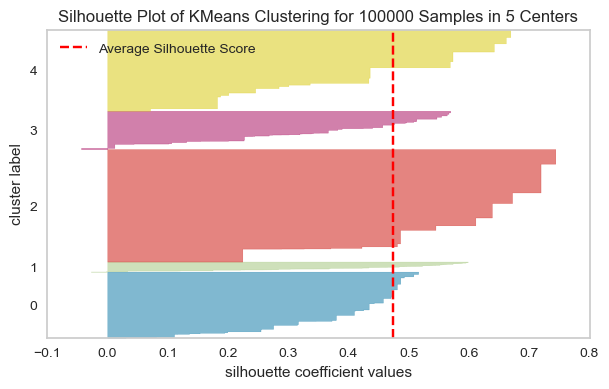

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 100000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [125]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(sample_)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Silhouette score is in the range between [-1,1].
The largest score in the same color(the same cluster) correspond to the data points closer to its centroids. The lowest score in the cluster refers to data points that are on the edge of the cluster (or we can say that this points are quite closer to other clusters). In our case the average score is near to 0,5 but there are some points, for example in the blue cluster, that have a score less than 0,1, it means that they are far from red Centroid and close to others.

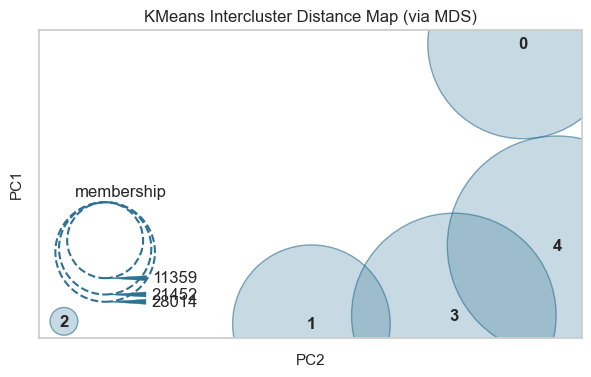

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [126]:
#Intercluster distance is the distance between two objects belonging to two different clusters
#Let's perform it in order to understand 'separation',distance among clusters.
from yellowbrick.cluster import InterclusterDistance

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(sample_)        # Fit the data to the visualizer
visualizer.show()

From the previous Intercluster plot we can observe as 3 clusters are more 'concentrated' and other 2 are more defined.

### Bonus

We remind you that we consider and grade the bonuses only if you complete the entire assignment.

1. Think about any two other clustering algorithms that you would like to use for the dataset (of course, you can use implemented version of them, e.g. from the scikit-learn library). Compare the results of chosen two algorithms with K-means implemented by you and K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [2]:
with open("df_kmeans.pkl", "rb") as file:
    df_kmeans = pickle.load(file)
df_kmeans_sub = df_kmeans.sample(n=100000)

In [3]:
df_kmeans_sub.shape

(100000, 6)

In [4]:
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN

In [29]:
start_time_optics = time.time()
clustering = OPTICS(n_jobs=-1).fit(df_kmeans_sub[['principal component 1', 'principal component 2',
                                       'principal component 3', 'principal component 4']])
prova2 = clustering.labels_
final_time_optics = round(time.time() - start_time_optics, 3)
print("--- %s seconds ---" % final_time_optics)

--- 694.361 seconds ---


In [9]:
start_time_dbscan = time.time()
clustering = DBSCAN(n_jobs=-1).fit(df_kmeans_sub[['principal component 1', 'principal component 2',
                                       'principal component 3', 'principal component 4']])
prova = clustering.labels_
final_time_dbscan = round(time.time() - start_time_dbscan, 3)
print("--- %s seconds ---" % final_time_dbscan)

--- 54.346 seconds ---


In [30]:
df_kmeans_sub['OPTICS'] = prova2
df_kmeans_sub['DBSCAN'] = prova
df_kmeans_sub.head()

,principal component 1,principal component 2,principal component 3,principal component 4,labelsPS,labelsKmeans++,OPTICS,DBSCAN
176454,-0.489761,-0.111212,1.322193,-0.833129,3,0,0,0
395029,-0.464369,-0.107126,1.375710,-0.838225,3,0,-1,0
112063,-0.025411,0.332379,1.243614,-0.071601,2,0,-1,0
662874,-0.388821,0.346185,-2.831576,-2.111520,4,1,2762,1
477074,-0.649833,-0.527746,1.241697,-0.346390,3,0,489,0


In [31]:
with open("df_clusters.pkl", "wb") as file:
    pickle.dump(df_kmeans_sub, file)

In [32]:
df_kmeans_sub.OPTICS.unique().size

2957

In [33]:
df_kmeans_sub.DBSCAN.unique().size

47

After trying all the methods in the cluster section of [sklearn](https://scikit-learn.org/stable/modules/clustering.html), the only two that ran in decent time and didn't blow up the computer were _DBSCAN_ and _OPTICS_. however, it was necessary to reduce the dimensionality of our dataset, in fact a random subset of 100.000 units was taken.

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster.

The OPTICS algorithm shares many similarities with the DBSCAN algorithm, and can be considered a generalization of DBSCAN that relaxes the eps requirement from a single value to a value range. The key difference between DBSCAN and OPTICS is that the OPTICS algorithm builds a reachability graph, which assigns each sample both a reachability_ distance, and a spot within the cluster ordering_ attribute; these two attributes are assigned when the model is fitted, and are used to determine cluster membership. If OPTICS is run with the default value of inf set for max_eps, then DBSCAN style cluster extraction can be performed repeatedly in linear time for any given eps value using the cluster_optics_dbscan method. Setting max_eps to a lower value will result in shorter run times, and can be thought of as the maximum neighborhood radius from each point to find other potential reachable points.

These two methods are known to scale well as the sample size increases as does the kmeans but at least in our case the results were somewhat disappointing given that with a dataset about 9 times smaller they still took much longer than the kmeans runned on the entire dataset. To be precise, the OPTICS took 694 seconds to converge, almost 12 minutes, while the DBSCAN 54 seconds. Times very far from the 3.5 seconds of kmeans++ (run on the whole dataset) and even worse than the 303 seconds (5 minutes) of our kmeans (always run on the whole dataset and without having been able to fully exploit the MapReduce potential).

Examining the results, it is then noted that the clusters created are totally different, in both methods implemented it is not possible to choose the number of clusters to be created beforehand, it is the algorithm that chooses. In particular, OPTICS created 2957 clusters, a huge number compared to the 5 we had chosen for kmeans, DBSCAN instead created 47 clusters, still far from the 5 of kmeans but not at extreme levels like the previous method. It is therefore difficult to say which is the method that has created a better clustering, they are based on different decision-making systems and depending on the data structure it may be convenient to choose one over another. In this specific case, however, it seems sensible to conclude that the best method to use is kmeans as it allows us to work on the whole dataset, it is faster and in addition it creates a smaller number of clusters which is more convenient for us to group similar users between of them, it would be of little help indeed to have 2962 usergroups but even with 47 we would not get what we want.

***

### Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tools that you know to answer the following questions using the same dataset that you have been using so far:

1. Which location has the maximum number of purchases been made?
2. In the dataset provided, did females spend more than males, or vice versa?
3. Report the customer with the highest average transaction amount in the dataset.

__Note__: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

### Algorithmic Question

An imaginary university wants to restrict its student’s entrance to the campus. Suppose that there are N entrances, M students and G guards. Due to the security measures, each student is known to be assigned a gate through which they should enter the university.

The N entrances will be numbered from 1 to N. Regarding one entry, the entrance will be opened right before the first student’s arrival and closed right after the arrival of the last student that should enter through that specific entrance. We will assume that two students can not enter the university simultaneously. For an entry to be protected, a guard should be assigned to it. Notice that a guard cannot leave his post until the door he was given is closed.

Assume that the university's head of the guards knows the order in which the students are coming to the university (yeah, they know you more than you know about yourself!). He wants you to help him if having only G guards is enough to address the restrictions they wish to apply (in other words, whether there will be a moment when more than G entrances should be opened or not).

__Input__

In the first line, you will be given the values of N, M and G, which correspond to the number of entrances to the university, the number of students in the university and the number of guards that the head of the guards intends to use to apply these restrictions respectively.

\begin{align}
1 &\leq N \leq 10^6 \\
1 &\leq M \leq 10^3 \\
1 &\leq G \leq 100 \\
\end{align}

In the second line, you will be given M integers which the ith integer corresponds to the entrance that has been assigned to the ith student to enter the university. Students will enter the university in the same order .

__Ouptut:__

Output “YES” if having G guards is enough to respect the restrictions, and “NO” if it is not enough.

__Examples:__

__Input 1__

__Output 2__

In this example, we only have one guard in the university. Initially, the guard will be assigned to protect entrance 1'. After the second student arrives, the guard will close access ‘1' and go to entrance '3'. In this case, having only one guard is enough to address the restrictions.

__Input 2__

__Output 2__

In [2]:
from collections import defaultdict

def findlastOccurIndex(num):
    return len(entrances) - entrances[-1::-1].index(num) - 1


def checkGuards(G):
    res = ''
    d = defaultdict()
    for i in range(len(entrances)):
        if d.get(entrances[i]) == i:
            G += 1
            del d[entrances[i]]
        else:
            if d.get(entrances[i]) is None:
                if G == 0:
                    res = "NO"
                    break
                else:
                    if findlastOccurIndex(entrances[i]) != i:
                        d[entrances[i]] = findlastOccurIndex(entrances[i])
                        G -= 1
                        continue

    print('YES' if res == '' else 'NO')


N, M, G = map(int, input().split())
entrances = list(map(int, input().split()))

checkGuards(G)

In [4]:
# Examples for the algorithm question

N, M, G = 4, 5, 1
entrances = [1, 1, 3, 3, 3]
print("Result with 1 guard and sequence 1 | 1 | 3 | 3 | 3 ")
checkGuards(G)

# -------------------------------------

N, M, G = 2, 5, 1
entrances = [1, 2, 1, 2, 2]
print("Result with 1 guard and sequence 1 | 2 | 1 | 2 | 2 ")
checkGuards(G)

Result with 1 guard and sequence 1 | 1 | 3 | 3 | 3 
YES
Result with 1 guard and sequence 1 | 2 | 1 | 2 | 2 
NO


The algorithm scrolling through the entire array initially checks whether the last student of any port has logged in. If this is true, the number of available guards is increased. After that it is checked whether the student who is entering is doing so on a new door. If this is true and the student is not the last one, a new guard is assigned to the door in question. If there are no guards, the program terminates by printing "NO".